In [1]:
%load_ext autoreload
%autoreload 2

# Wind-up example using SMARTEOLE dataset

Dataset citation:
Thomas Duc, & Eric Simley. (2022): [SMARTEOLE Wind Farm Control open dataset (1.0)](https://doi.org/10.5281/zenodo.7342466)

See the [wind-up uplift validation methodology](https://github.com/resgroup/wind-up/blob/main/docs/wind-up%20uplift%20validation%20methodology%20v3.pdf) for a description of the calculation methodology.

In [2]:
from helpers import setup_logger

setup_logger()

## 1. downloading the open dataset

In [3]:
from helpers import download_zenodo_data

from wind_up.constants import OUTPUT_DIR, PROJECTROOT_DIR

filename = "SMARTEOLE-WFC-open-dataset.zip"
outpur_dir = PROJECTROOT_DIR / "tests" / "test_data" / "smarteole"

download_zenodo_data(
    record_id="7342466",
    output_dir=outpur_dir,
    filenames=[filename],
    cache_overwrite=False,  # change to True if you want to force the re-download
)

All filenames are locally cached, no download necessary.


## 2. extracting and format the data

In [4]:
from smarteole_utils import SmartEoleExtractor

analysis_timebase_s = 60

extractor = SmartEoleExtractor.from_zip_file(
    zipped_fpath=outpur_dir / filename,
    analysis_timebase_s=analysis_timebase_s,
)

#### 2.1 scada data

In [5]:
scada_df = extractor.unpack_smarteole_scada()
scada_df.head(3)

C:\Users\aclerc\Github\wind-up\.venv\Lib\site-packages\pandas\core\resample.py:450: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  func = lambda x: how(x, *args, **kwargs)


TurbineName  ActivePowerMean  ActivePowerSD  \
TimeStamp_StartFormat                                               
2020-02-17 16:30:00          SMV1         2023.747         53.175   
2020-02-17 16:31:00          SMV1         1959.036        142.397   
2020-02-17 16:32:00          SMV1         2053.659         28.154   

                       WindSpeedMean  WindSpeedSD  YawAngleMean  YawAngleMin  \
TimeStamp_StartFormat                                                          
2020-02-17 16:30:00           13.066        0.877        239.93       239.93   
2020-02-17 16:31:00           12.091        1.552        239.93       239.93   
2020-02-17 16:32:00           13.381        1.452        239.93       239.93   

                       YawAngleMax  PitchAngleMean  GenRpmMean  AmbientTemp  \
TimeStamp_StartFormat                                                         
2020-02-17 16:30:00         239.93           4.349    1800.340       11.603   
2020-02-17 16:31:00         239.93           2.338    1803.513       11.603   
2020-02-17 16:32:00         239.93           5.374    1804.557       11.604   

                       ShutdownDuration  
TimeStamp_StartFormat                    
2020-02-17 16:30:00                   0  
2020-02-17 16:31:00                   0  
2020-02-17 16:32:00                   0

#### 2.2 metadata

In [6]:
metadata_df = extractor.unpack_smarteole_metadata()
metadata_df.head(3)

Name  Latitude  Longitude TimeZone  TimeSpanMinutes TimeFormat
0  SMV1  49.84975    2.80194      UTC              1.0      Start
1  SMV2  49.84661    2.80150      UTC              1.0      Start
2  SMV3  49.84347    2.80162      UTC              1.0      Start

#### 2.3 toggle data
toggle data is data from the controller running the toggle test, in this case a wake steering controller

In [7]:
toggle_df = extractor.unpack_smarteole_toggle_data()
toggle_df[toggle_df["yaw_offset_command"] > 10].head(3)  # noqa: PLR2004

toggle_on  toggle_off  yaw_offset_command
TimeStamp_StartFormat                                               
2020-02-18 07:00:00+00:00      False       False              12.899
2020-02-18 07:01:00+00:00       True       False              14.761
2020-02-18 07:02:00+00:00       True       False              12.794

## 3. Get reference data
We'll use nearby ERA5 re-analysis data, previously downloaded

In [8]:
import pandas as pd

from wind_up.reanalysis_data import ReanalysisDataset

reanalysis_dataset = ReanalysisDataset(
    id="ERA5T_50.00N_2.75E_100m_1hr",
    data=pd.read_parquet(
        PROJECTROOT_DIR / "tests/test_data/smarteole/ERA5T_50.00N_2.75E_100m_1hr_20200201_20200531.parquet"
    ),
)
reanalysis_dataset.data.head(3)

10_m_hws_mean_mps  10_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                       
2020-02-01 00:00:00+00:00               6.29                     203.1   
2020-02-01 01:00:00+00:00               6.57                     204.3   
2020-02-01 02:00:00+00:00               6.54                     209.5   

                           100_m_hws_mean_mps  100_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00               10.33                      206.6   
2020-02-01 01:00:00+00:00               10.80                      207.4   
2020-02-01 02:00:00+00:00               10.69                      212.1   

                           2_m_temp_mean_deg-c  2_m_dew_point_temp_deg-c  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                 11.6                       9.8   
2020-02-01 01:00:00+00:00                 11.6                      10.2   
2020-02-01 02:00:00+00:00                 11.6                      10.7   

                           2_m_rh_mean_%  0_m_pres_mean_pa  \
datetime_start_utc                                           
2020-02-01 00:00:00+00:00           88.9           99621.8   
2020-02-01 01:00:00+00:00           91.2           99547.5   
2020-02-01 02:00:00+00:00           93.9           99486.1   

                           sea_level_pres_mean_pa  boundary_layer_height_m  \
datetime_start_utc                                                           
2020-02-01 00:00:00+00:00                100815.6                    834.2   
2020-02-01 01:00:00+00:00                100739.8                    813.0   
2020-02-01 02:00:00+00:00                100678.0                    808.8   

                           total_cloud_cover_%  \
datetime_start_utc                               
2020-02-01 00:00:00+00:00                100.0   
2020-02-01 01:00:00+00:00                100.0   
2020-02-01 02:00:00+00:00                100.0   

                           instantaneous_surface_sensible_heat_flux_wpm2  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                                         30.138   
2020-02-01 01:00:00+00:00                                         33.538   
2020-02-01 02:00:00+00:00                                         32.996   

                           friction_velocity_mps  cloud_base_height_m  \
datetime_start_utc                                                      
2020-02-01 00:00:00+00:00               0.441049                204.6   
2020-02-01 01:00:00+00:00               0.435240                 30.8   
2020-02-01 02:00:00+00:00               0.424339                 30.8   

                           surface_solar_radiation_downwards_wpm2  era5t  
datetime_start_utc                                                        
2020-02-01 00:00:00+00:00                                     0.0      0  
2020-02-01 01:00:00+00:00                                     0.0      0  
2020-02-01 02:00:00+00:00                                     0.0      0

## 4. Define the assessment configuration

In [9]:
from wind_up.models import Asset, PlotConfig, Toggle, Turbine, WindUpConfig

#### 4.1 defining the turbine information

In [10]:
wtg_map = {
    f"SMV{i}": Turbine.model_validate(
        {
            "name": f"SMV{i}",
            "turbine_type": {
                "turbine_type": "Senvion-MM82-2050",
                "rotor_diameter_m": 82.0,
                "rated_power_kw": 2050.0,
                "normal_operation_pitch_range": (-10.0, 35.0),
                "normal_operation_genrpm_range": (250.0, 2000.0),
            },
        }
    )
    for i in range(1, 7 + 1)
}

#### 4.2 defining northing corrections
Northing corrections are defined by running the analysis with `WindUpConfig.optimize_northing_corrections` set to `True`. The northing correction calculation is time consuming; it is generally acceptable to run it one time on a particular dataset and then preserve the result as config thereafter.

In [11]:
northing_corrections_utc = [
    ("SMV1", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.750994540354649),
    ("SMV2", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.690999999999994),
    ("SMV3", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.558000000000042),
    ("SMV4", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.936999999999996),
    ("SMV5", pd.Timestamp("2020-02-17 16:30:00+0000"), 6.797253350869262),
    ("SMV6", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.030130916842758),
    ("SMV7", pd.Timestamp("2020-02-17 16:30:00+0000"), 4.605999999999972),
]

#### 4.3 defining the WindUp and Plot configurations

In [12]:
analysis_output_dir = OUTPUT_DIR / "smarteole_example"

# allowing bigger margin if analysing at lower frequency
wd_filter_margin = 3 + 7 * analysis_timebase_s / 600

cfg = WindUpConfig(
    assessment_name="smarteole_example",
    timebase_s=analysis_timebase_s,
    require_ref_wake_free=True,
    detrend_min_hours=12,  # shorter than the default of 24 because this dataset is small
    ref_wd_filter=[207 - wd_filter_margin, 236 + wd_filter_margin],  # steer is from 207-236
    filter_all_test_wtgs_together=True,
    use_lt_distribution=False,
    out_dir=analysis_output_dir,
    test_wtgs=[wtg_map["SMV6"], wtg_map["SMV5"]],
    ref_wtgs=[wtg_map["SMV7"]],
    ref_super_wtgs=[],
    non_wtg_ref_names=[],
    analysis_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    upgrade_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    analysis_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    lt_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    lt_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    detrend_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    detrend_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    years_for_lt_distribution=0,
    years_for_detrend=0,
    ws_bin_width=1.0,
    asset=Asset(name="Sole du Moulin Vieux", wtgs=list(wtg_map.values()), masts_and_lidars=[]),
    northing_corrections_utc=northing_corrections_utc,
    toggle=Toggle(
        name="wake steering",
        toggle_file_per_turbine=False,
        toggle_filename="SMV_offset_active_toggle_df.parquet",
        detrend_data_selection="use_toggle_off_data",
        pairing_filter_method="any_within_timedelta",
        pairing_filter_timedelta_seconds=3600,
        toggle_change_settling_filter_seconds=120,
    ),
)

plot_cfg = PlotConfig(show_plots=True, save_plots=False, skip_per_turbine_plots=True, plots_dir=cfg.out_dir / "plots")

loaded WindUpConfig assessment_name: smarteole_example
toggle analysis period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00
long term period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00
detrend period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00


#### 4.3 combining all configurations into the assessment inputs object
This object bundles everything needed to run the wind-up analysis
In particular the wind farm SCADA data is filtered and northed.

A wind speed estimate for each turbine is also derived mainly from power so that the anemometer data is used as little as possible.  

running wind_up analysis for smarteole_example
running load_smart_scada_and_md_from_file for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:59:00+00:00
loaded 7 turbines, 0.3 years per turbine
finished load_smart_scada_and_md for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:59:00+00:00


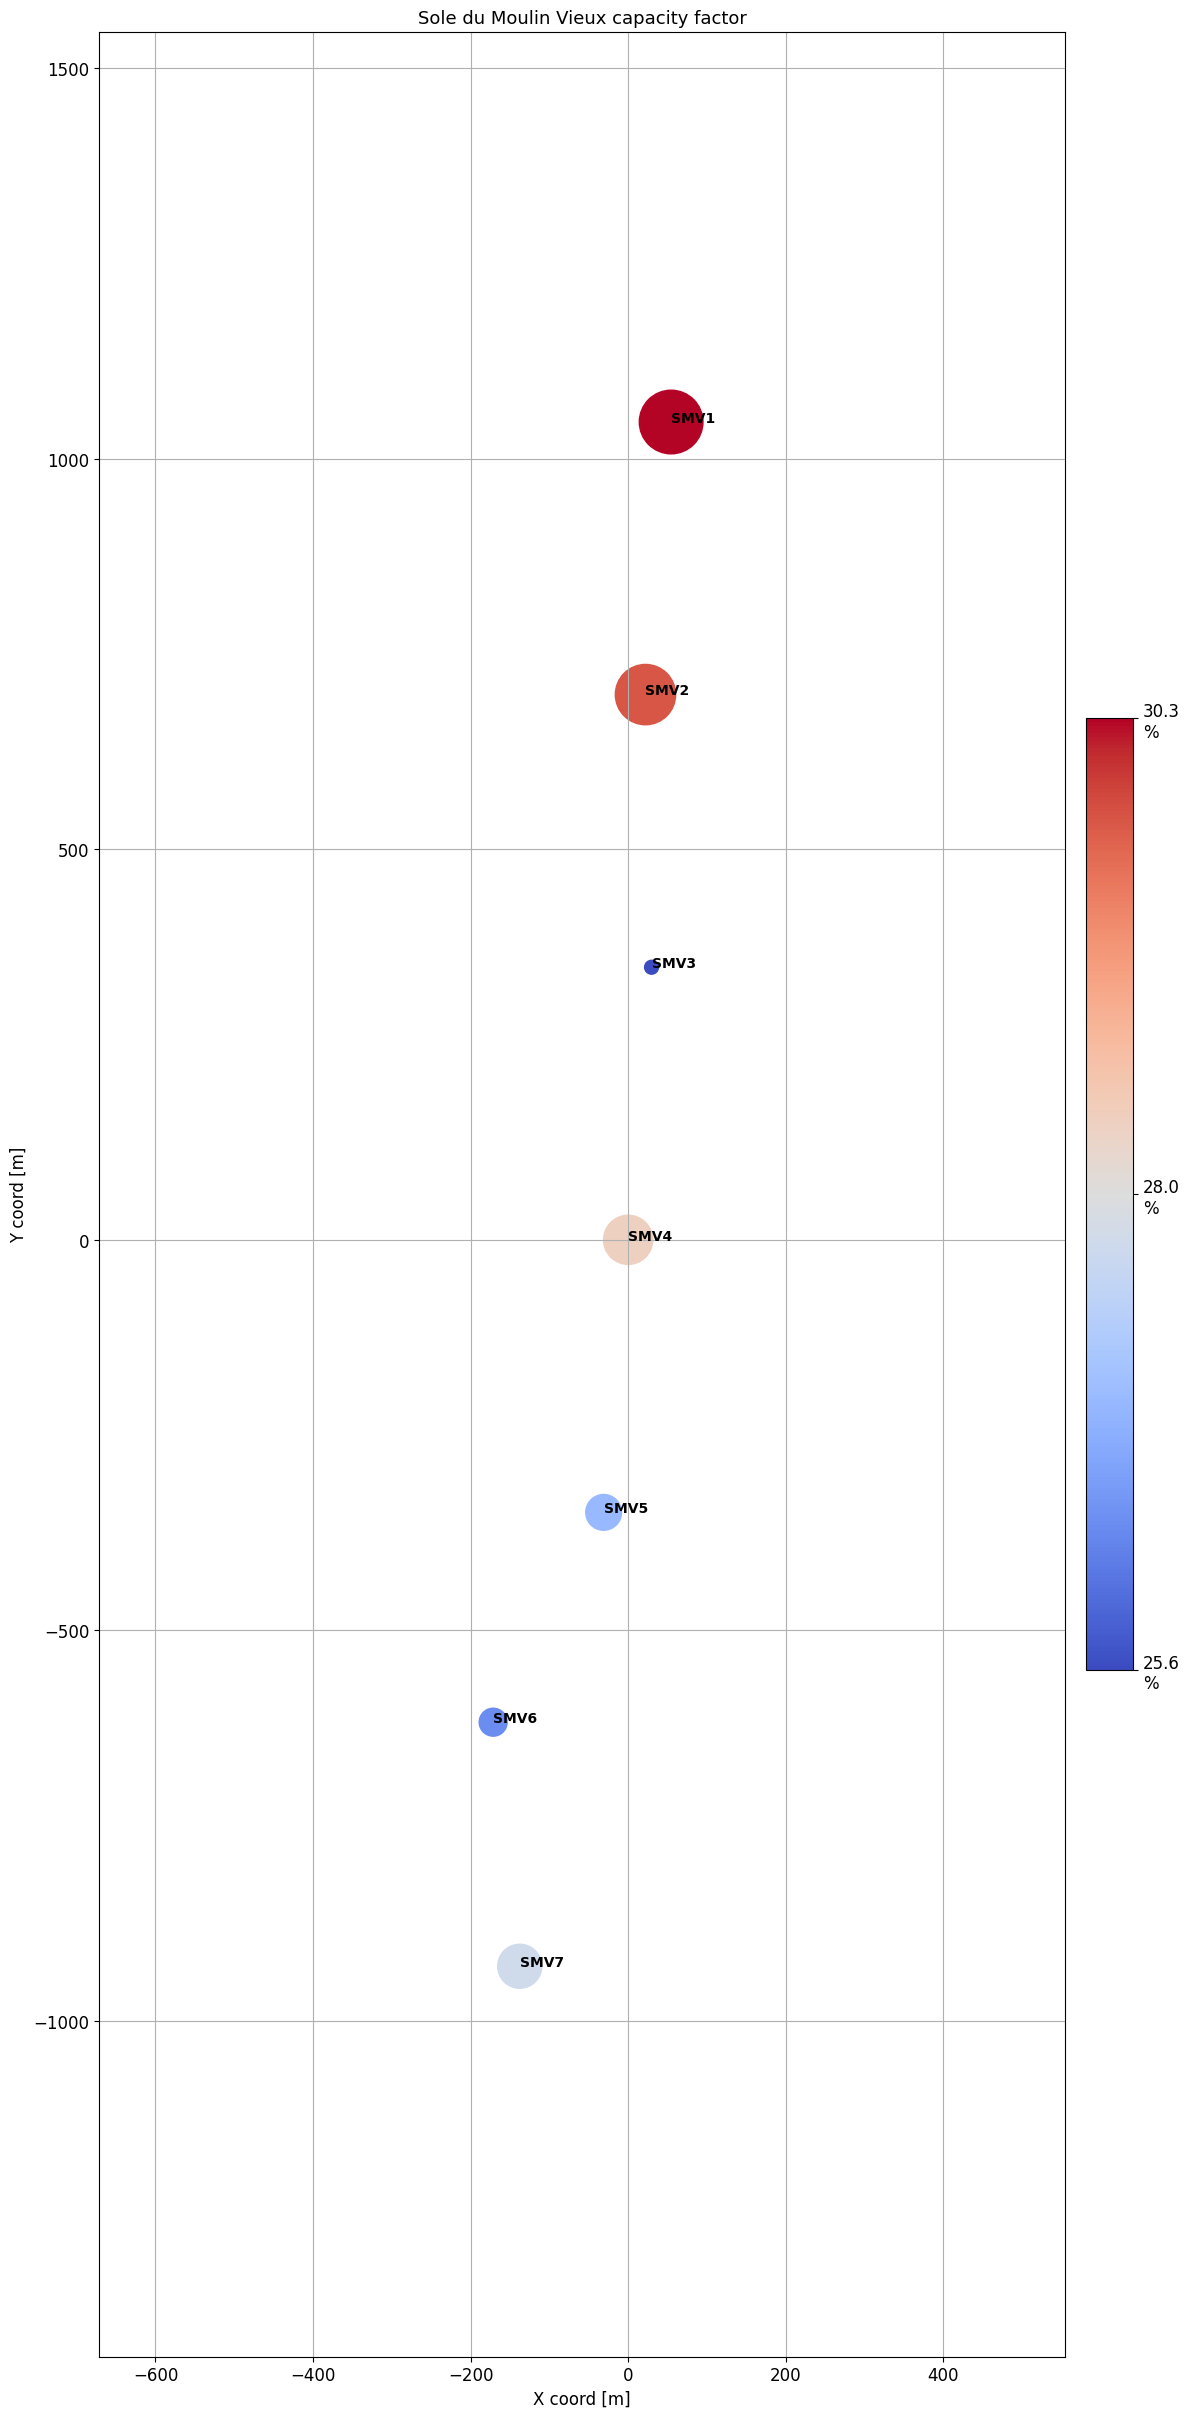

average capacity factor: 27.9%
top 3 capacity factor [%]:
+------+------+
| SMV1 | 30.3 |
| SMV2 | 29.8 |
| SMV4 | 28.3 |
+------+------+
bottom 3 capacity factor [%]:
+------+------+
| SMV3 | 25.6 |
| SMV6 | 26.3 |
| SMV5 | 26.9 |
+------+------+


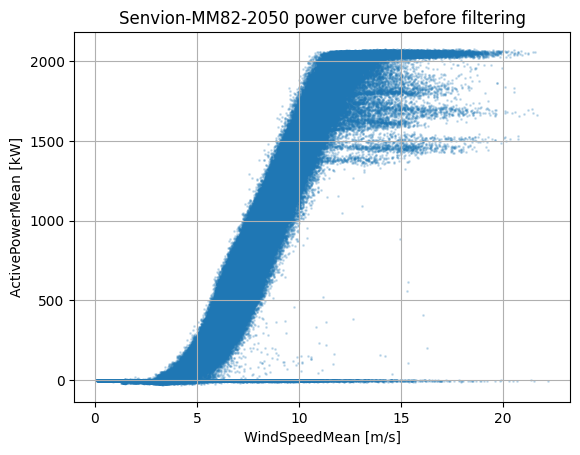

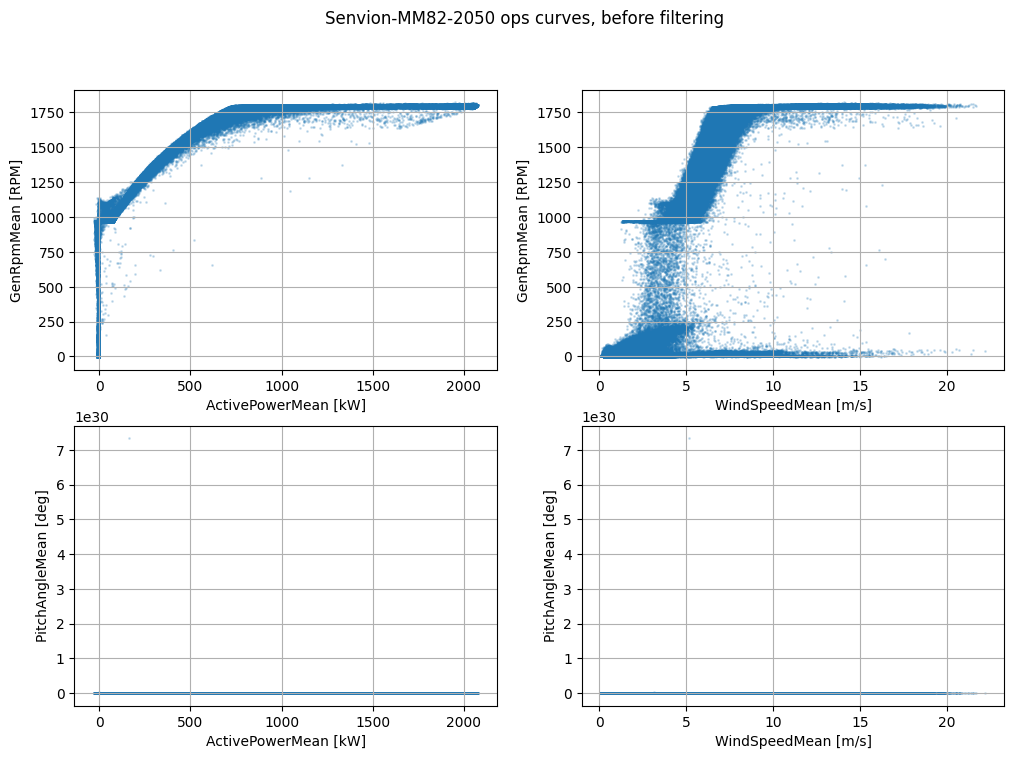

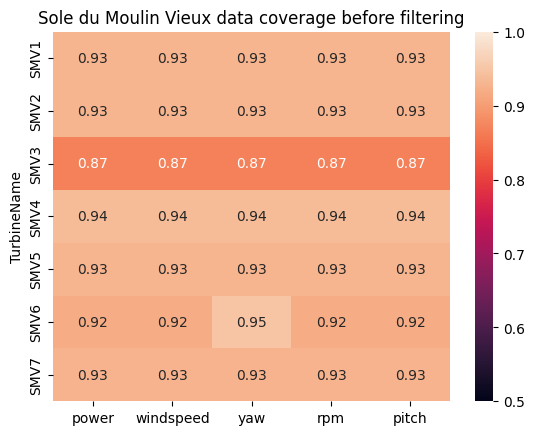

78956 rows [8.0%] of power data is missing before filtering
filter_stuck_data set 74828 rows [7.6%] to NA
filter_bad_pw_ws set 0 rows [0.0%] to NA
rows with PitchAngleMean lt -180: 0
rows with PitchAngleMean ge 180: 7
wrapped PitchAngleMean to -180-180
filter_wrong_yaw set 210977 rows [21.5%] to NA yaw Min & Max because of bad YawAngleMin/Max values
filter_wrong_yaw set 5 rows [0.0%] to NA yaw because of YawAngleMean appears to be wrong
filter_exclusions set 0 rows [0.0%] to NA
filter_yaw_exclusions set 0 rows [0.0%] to NA yaw
filter_downtime set 0 rows [0.0%] to NA


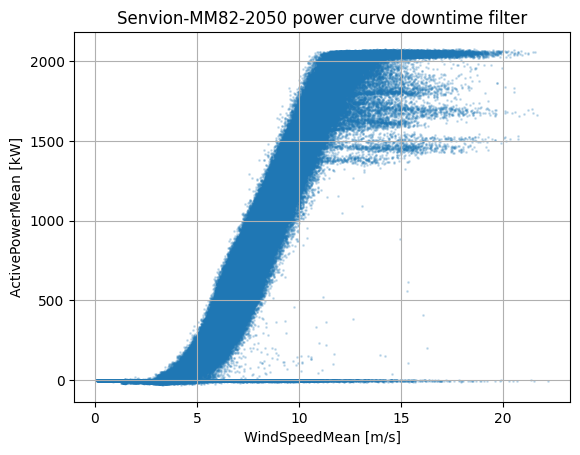

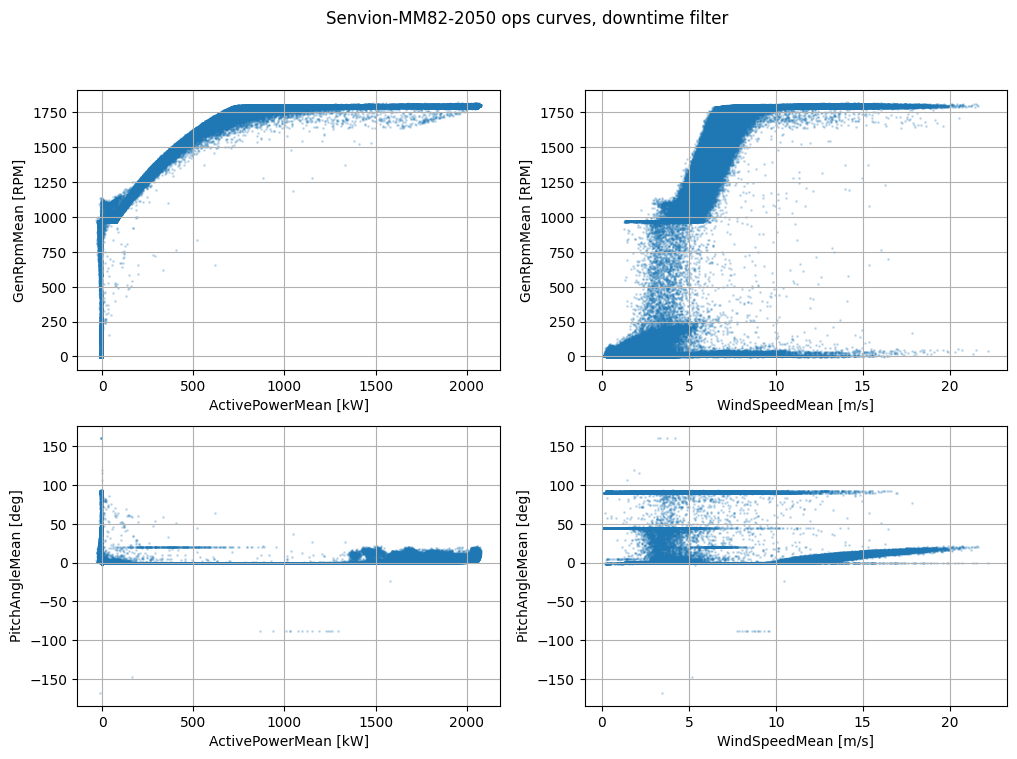

filter_missing_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are NA
filter_rpm_and_pt set 140987 rows [14.4%] to NA because of rpm or pitch are out of range


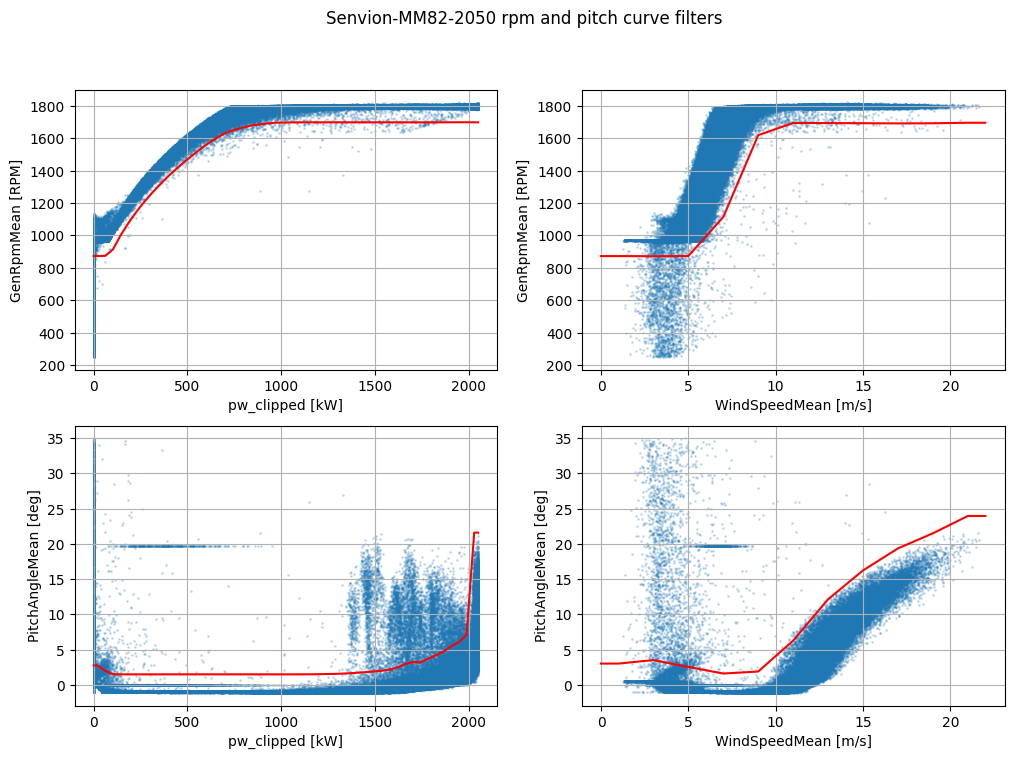

filter_rpm_and_pt set 11779 rows [1.2%] to NA because of rpm or pitch curve filtering


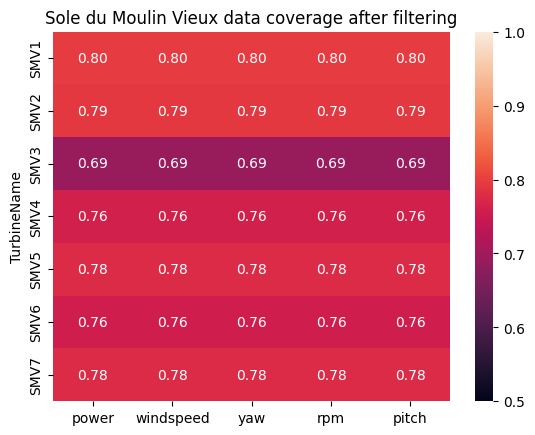

231722 rows [23.6%] of power data is missing after filtering


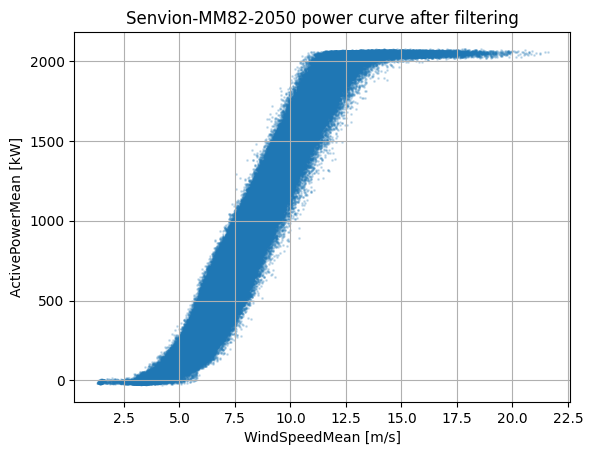

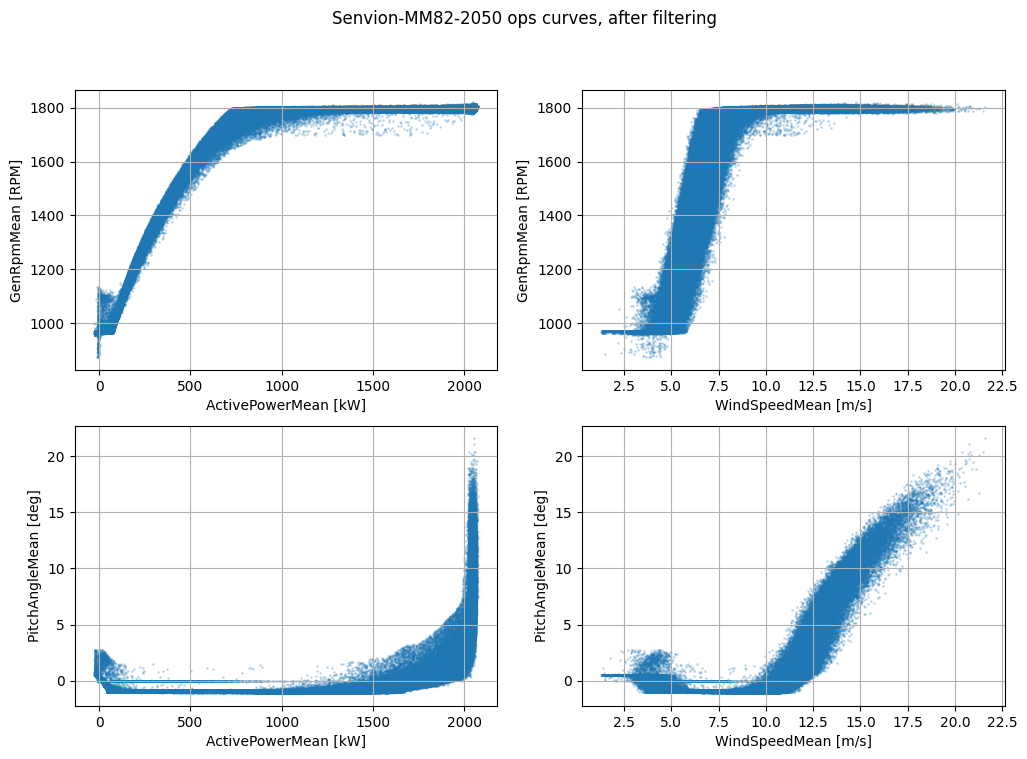

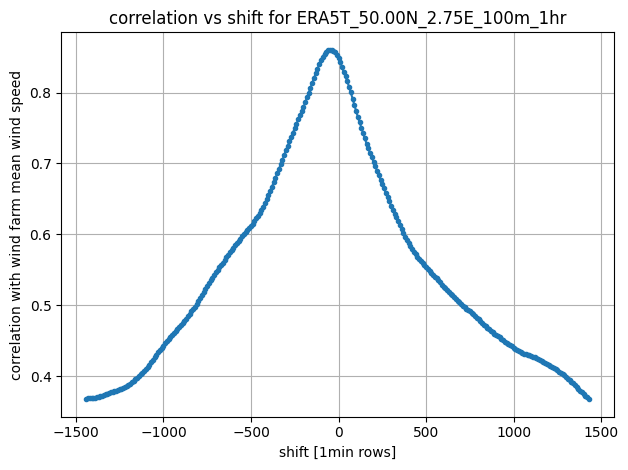

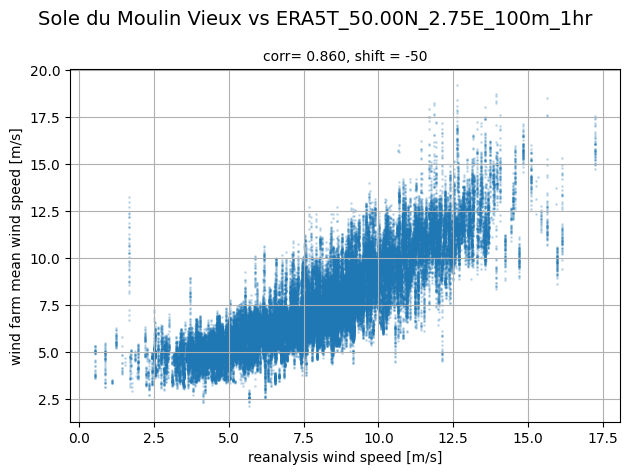

ERA5T_50.00N_2.75E_100m_1hr best correlation is 0.860442 with a shift of -50
ERA5T_50.00N_2.75E_100m_1hr has best correlation: 0.860 with a shift of -50


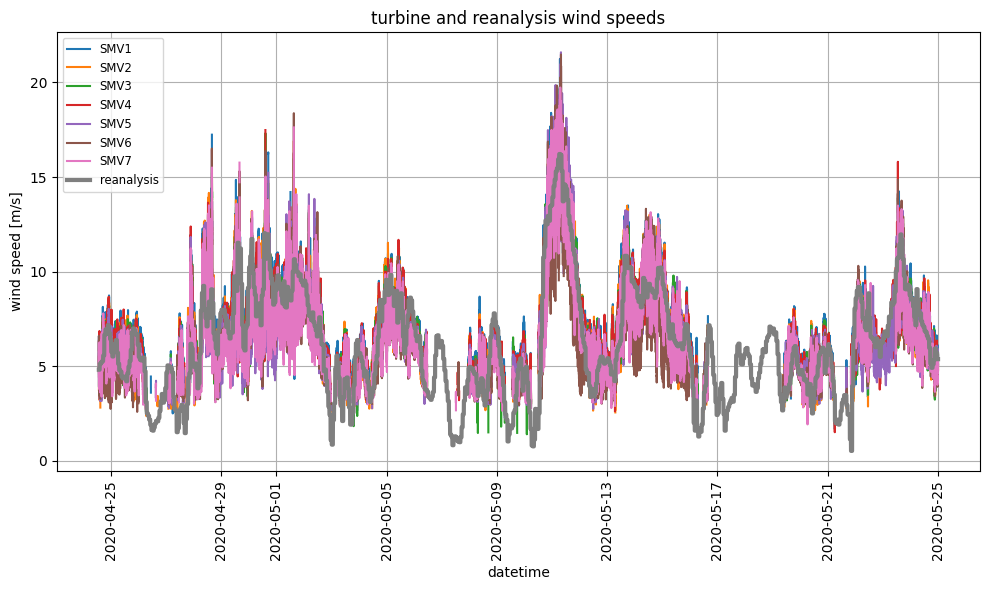

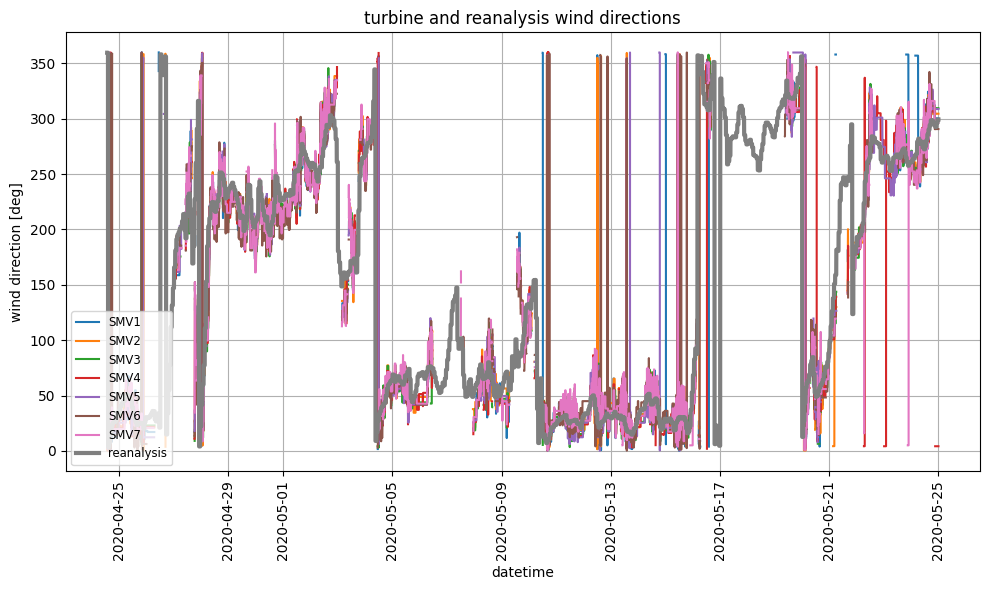

top 3 turbines needing northing correction vs reanalysis_wd before northing:
+------+------+
| SMV6 | 11.6 |
| SMV5 | 11.2 |
| SMV4 | 10.5 |
+------+------+
top 3 REFERENCE turbines needing northing correction vs reanalysis_wd before northing:
+------+-----+
| SMV7 | 8.7 |
+------+-----+


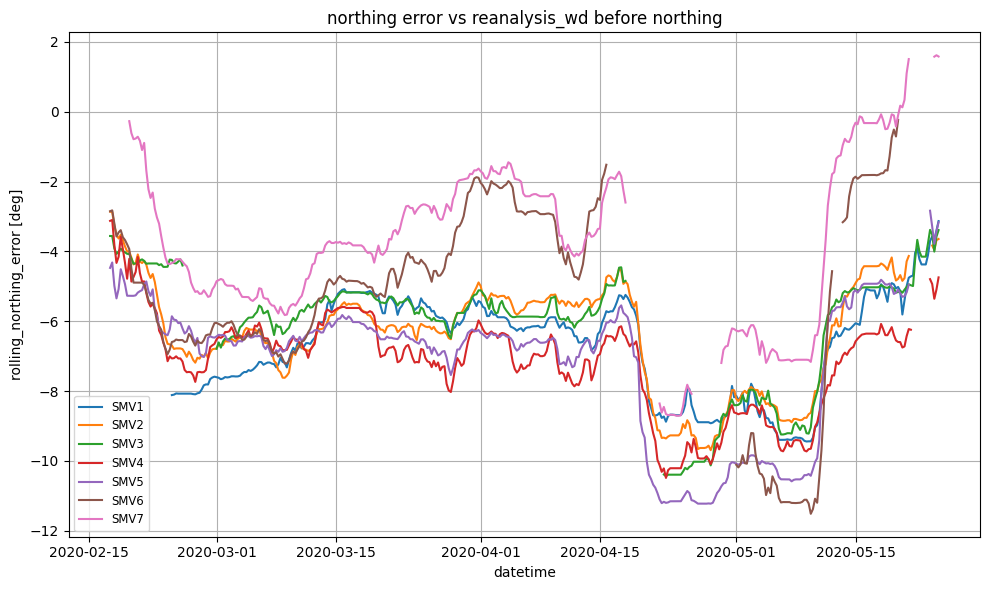

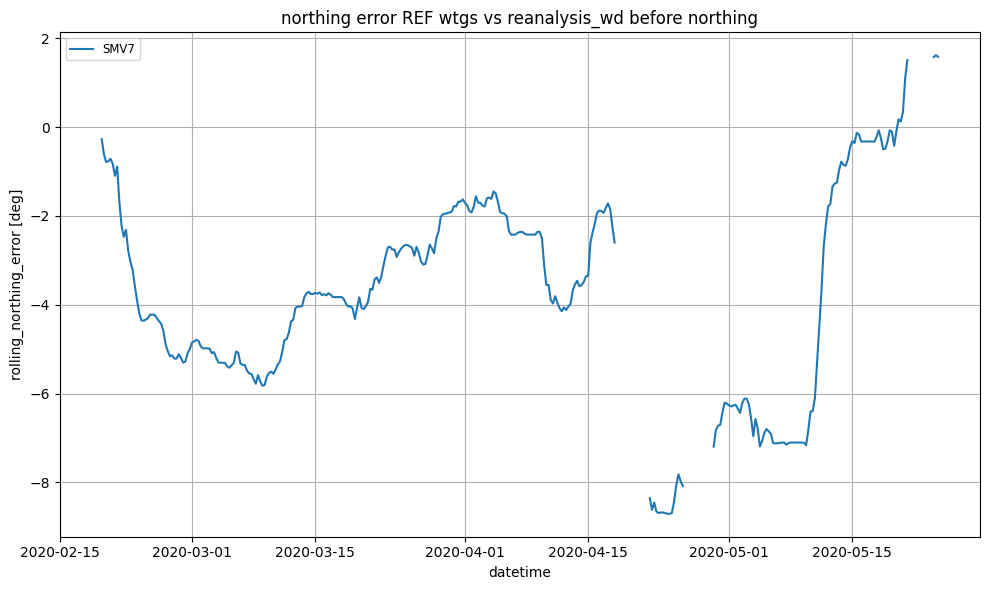

applied 7 northing corrections
top 3 turbines needing northing correction vs reanalysis_wd after northing:
+------+-----+
| SMV6 | 6.6 |
| SMV7 | 6.3 |
| SMV3 | 4.9 |
+------+-----+
top 3 REFERENCE turbines needing northing correction vs reanalysis_wd after northing:
+------+-----+
| SMV7 | 6.3 |
+------+-----+


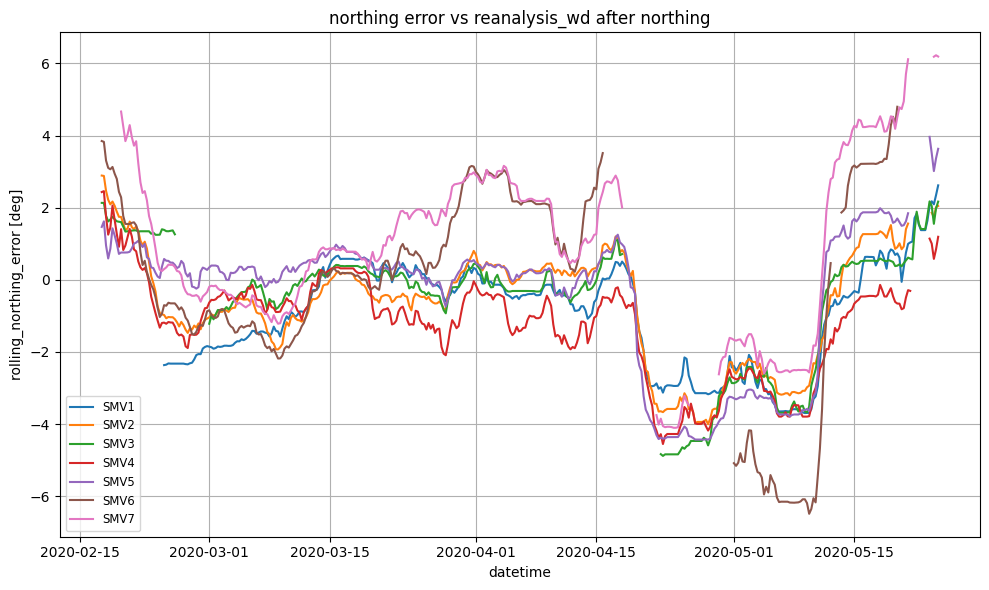

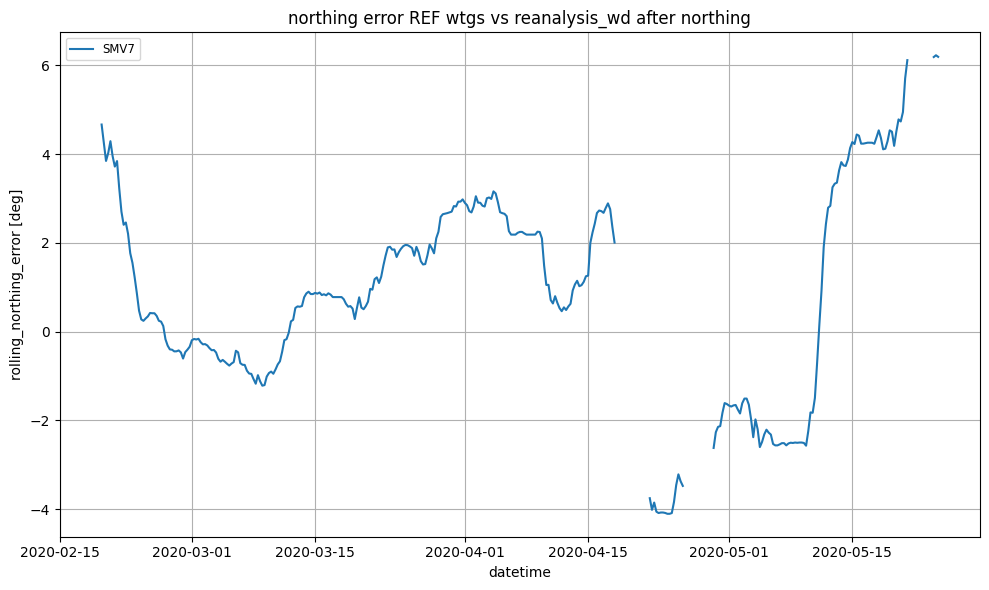

estimated rated wind speed = 13.7 m/s
estimated cut-in wind speed = 3.3 m/s


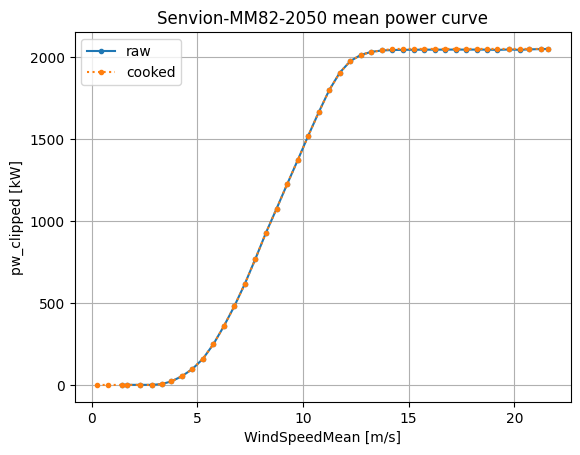

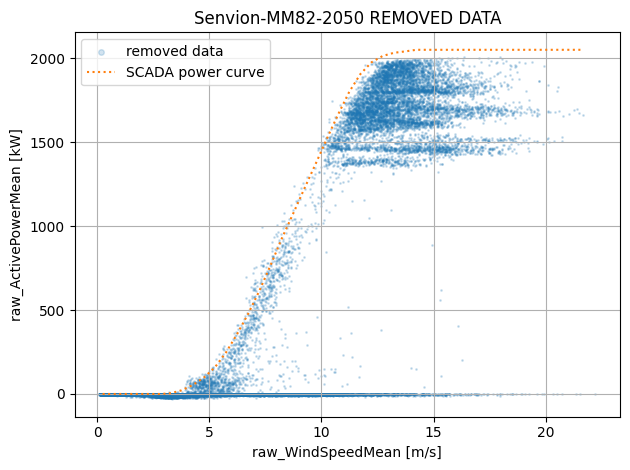

##############################################################################
# estimate wind speed from power
##############################################################################
SMV1 cp correction factor = 0.97
SMV2 cp correction factor = 0.99
SMV3 cp correction factor = 1.00
SMV4 cp correction factor = 0.98
SMV5 cp correction factor = 1.02
SMV6 cp correction factor = 1.03
SMV7 cp correction factor = 1.02


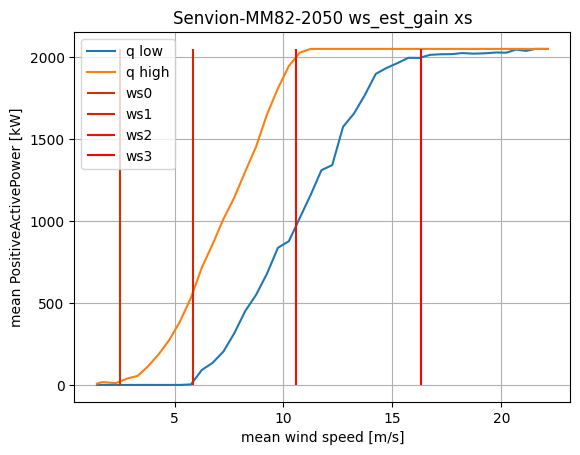

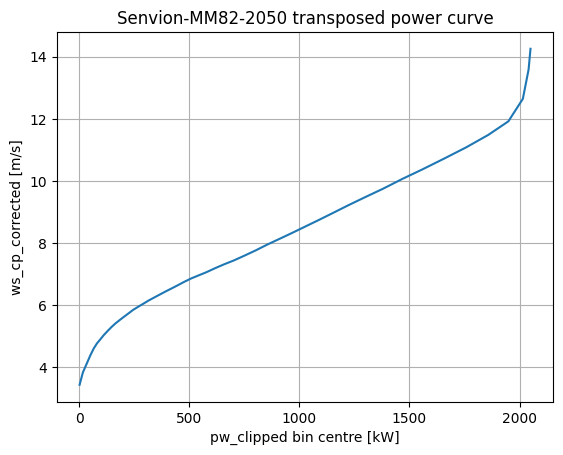

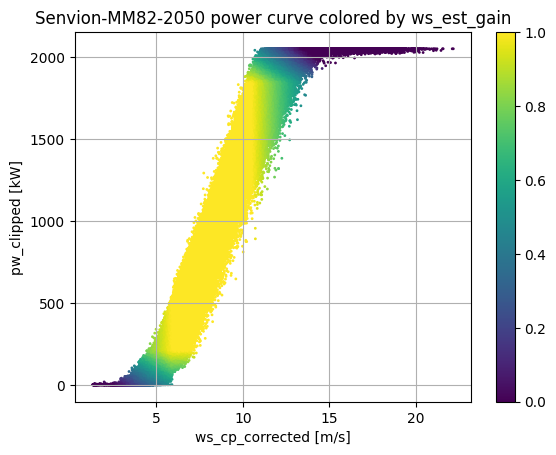

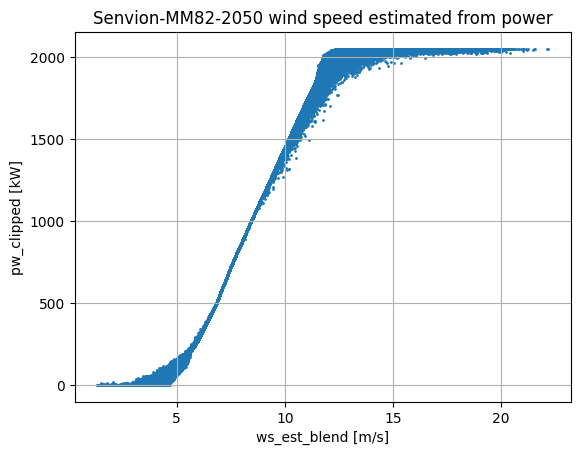

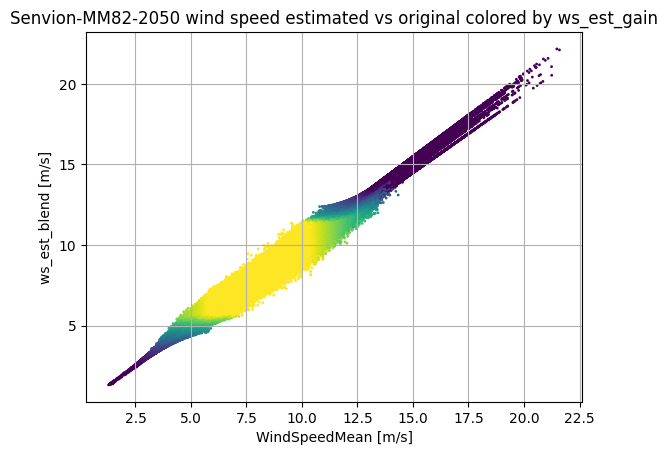

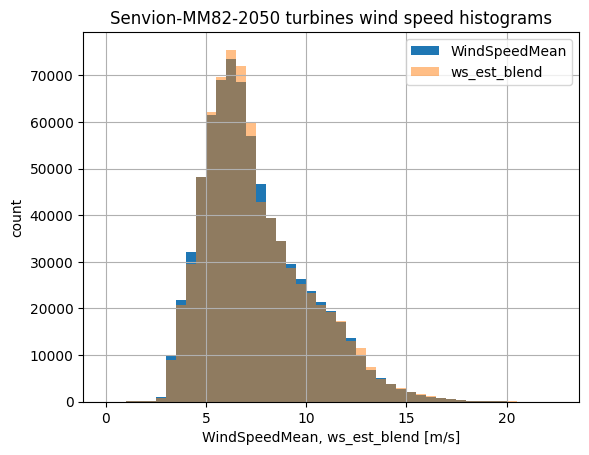

Senvion-MM82-2050 77.0% of rows are waking
Senvion-MM82-2050 14.6% of rows are not waking
Senvion-MM82-2050 8.4% of rows have unknown or partial waking


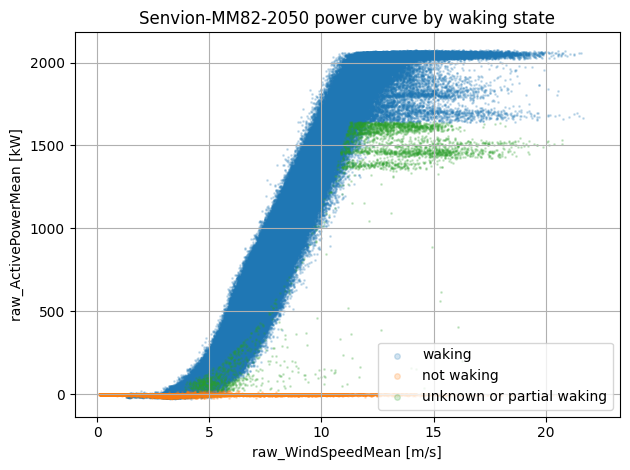

In [13]:
from wind_up.interface import AssessmentInputs

assessment_inputs = AssessmentInputs.from_cfg(
    cfg=cfg,
    plot_cfg=plot_cfg,
    toggle_df=toggle_df,
    scada_df=scada_df,
    metadata_df=metadata_df,
    reanalysis_datasets=[reanalysis_dataset],
    cache_dir=None,
)

## 5. Running the assessment

test turbines: ['SMV6', 'SMV5']
ref list: ['SMV7']
turbines to test: ['SMV6', 'SMV5']
filter_all_test_wtgs_together SMV5 set 3960 rows [2.8%] to NA


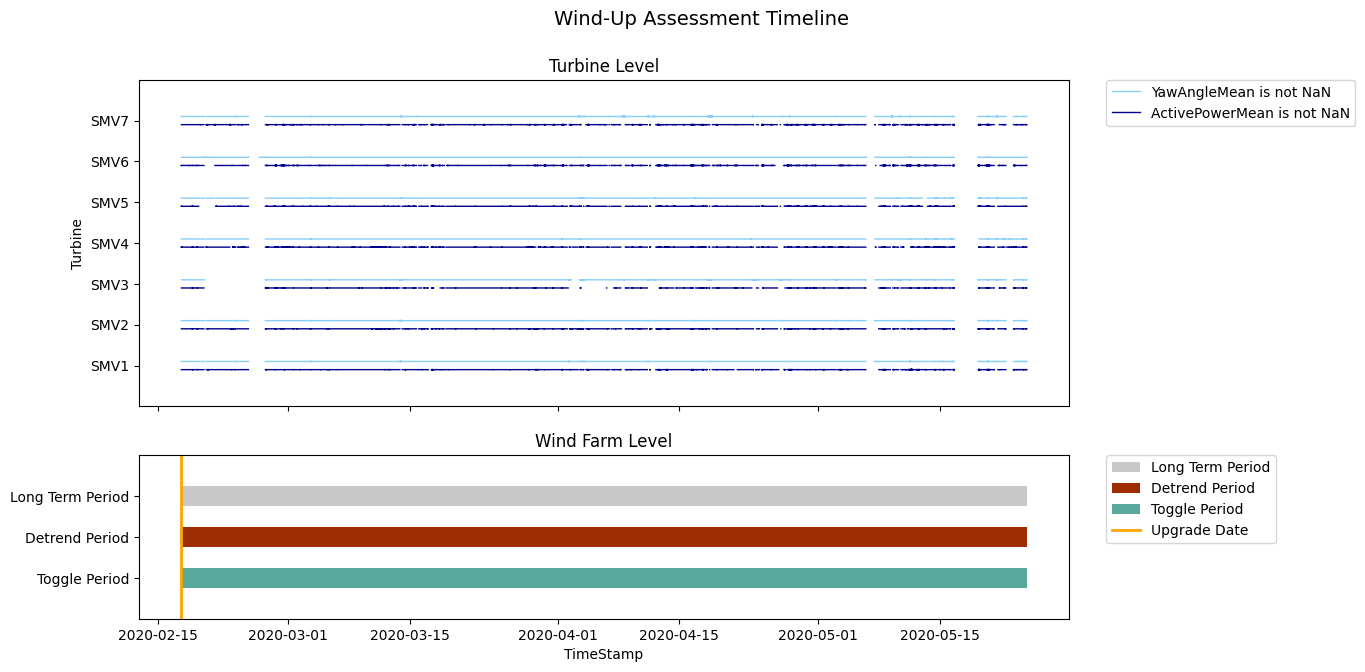

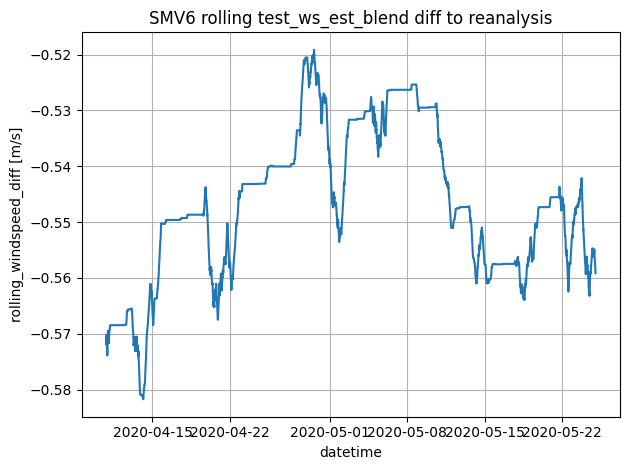

changed 262 [0.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 221 [0.3%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120


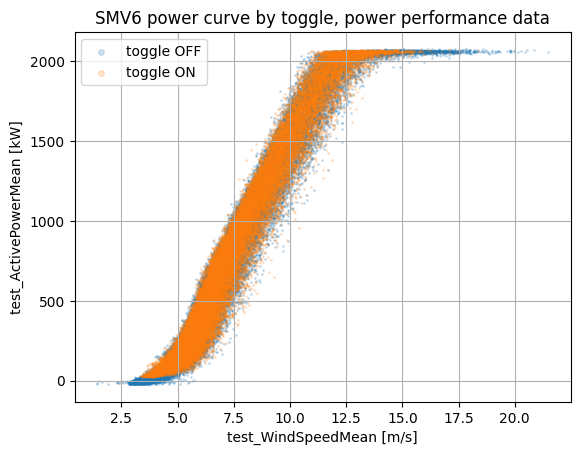

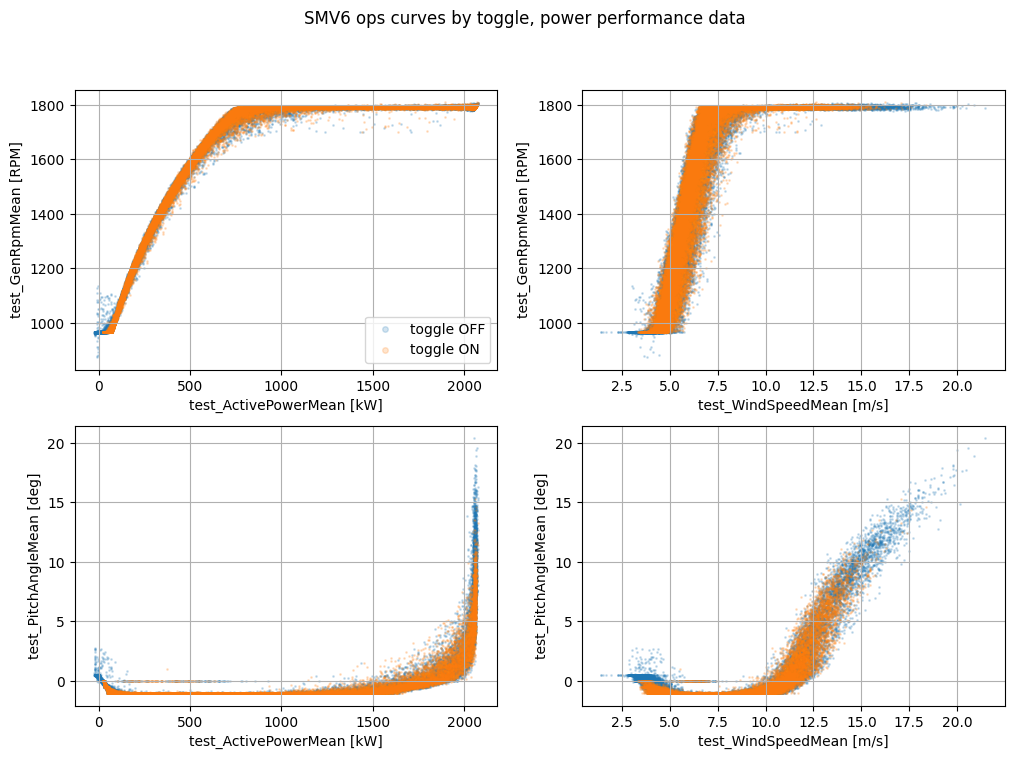

analysing SMV6 SMV7, loop_counter=0
changed 262 [0.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 221 [0.3%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
removed 120279 [85.8%] rows from ref_df using ref_wd_filter
SMV7 wake free directions with data min=203.0 max=240.0
removed 0 [0.0%] rows from ref_df using require_ref_wake_free


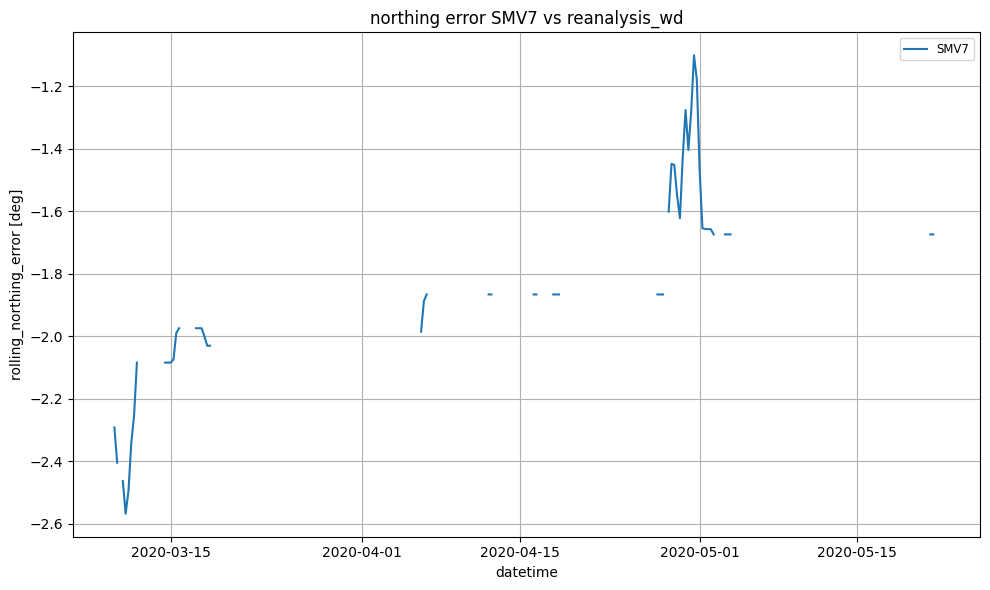

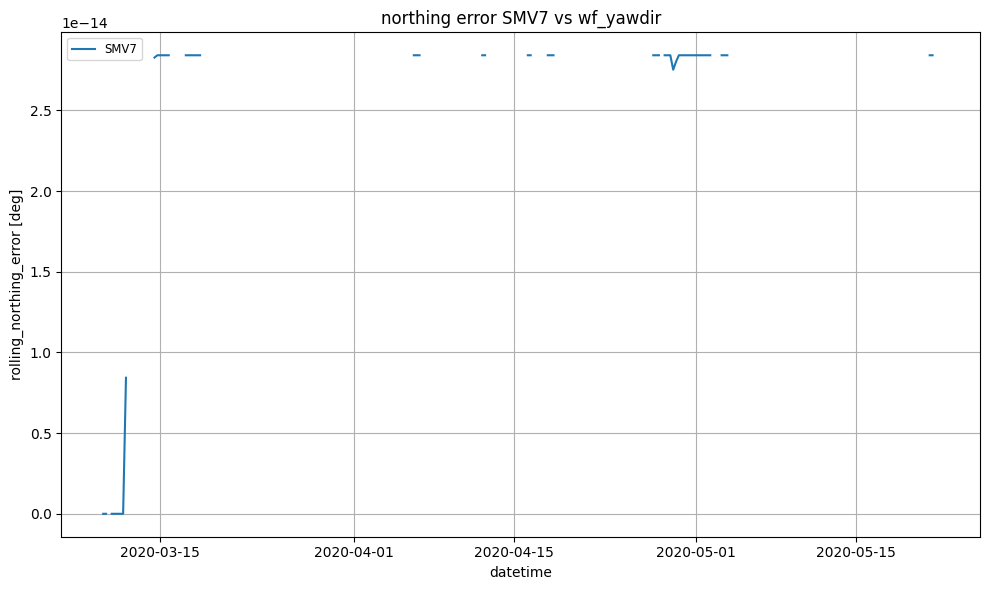

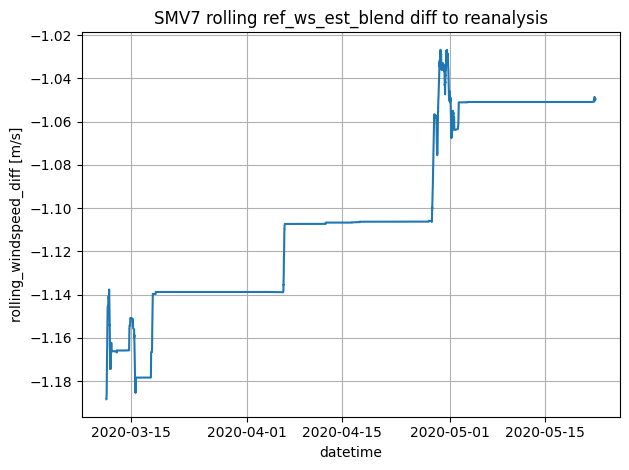

removed 61276 [43.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time
top 2 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
| SMV7 offline |   0.0 |
+--------------+-------+


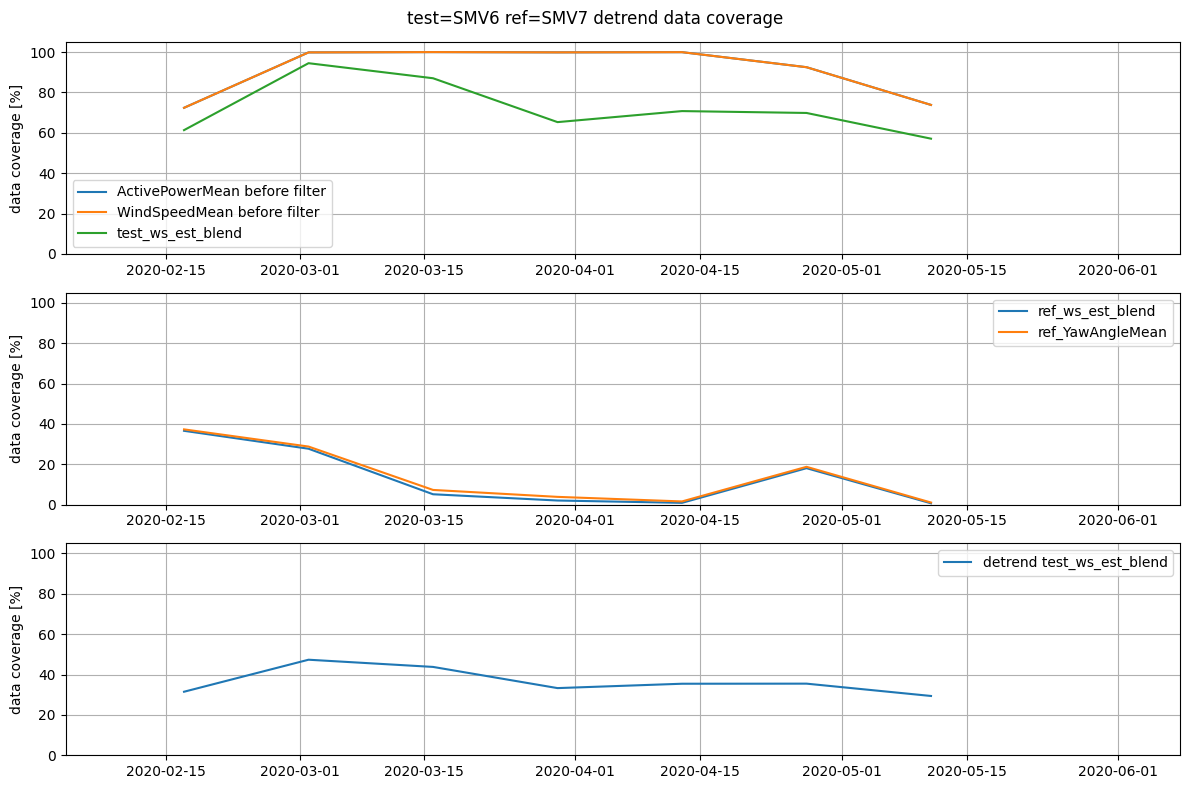

removed 0 bad detrend results


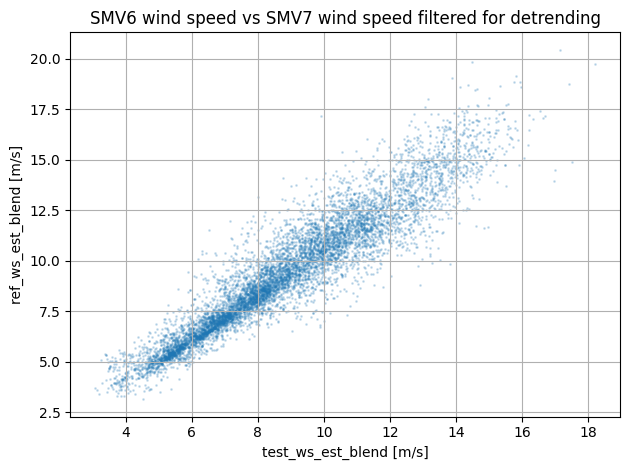

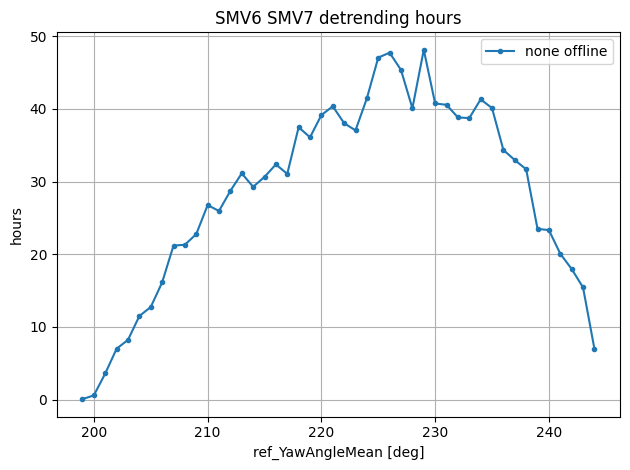

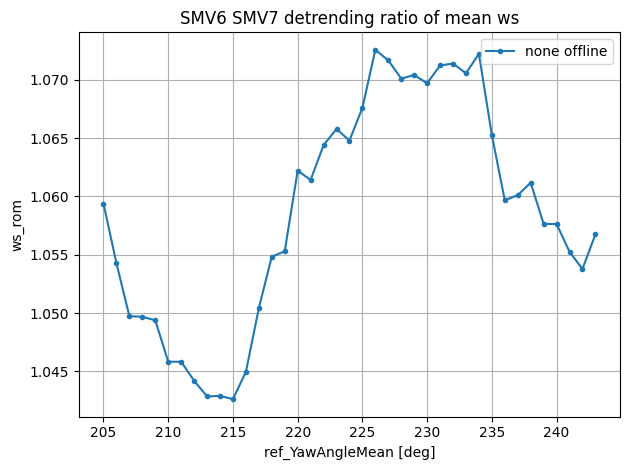

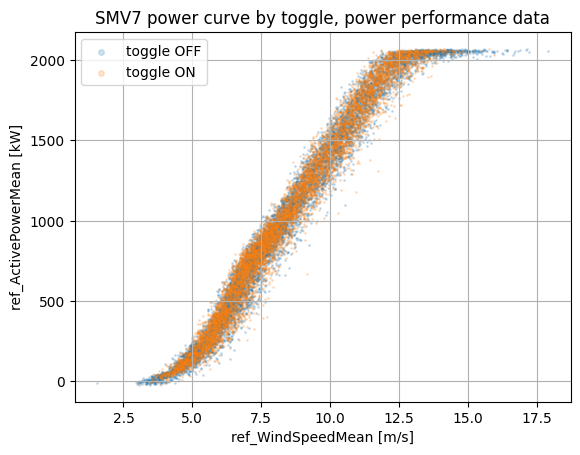

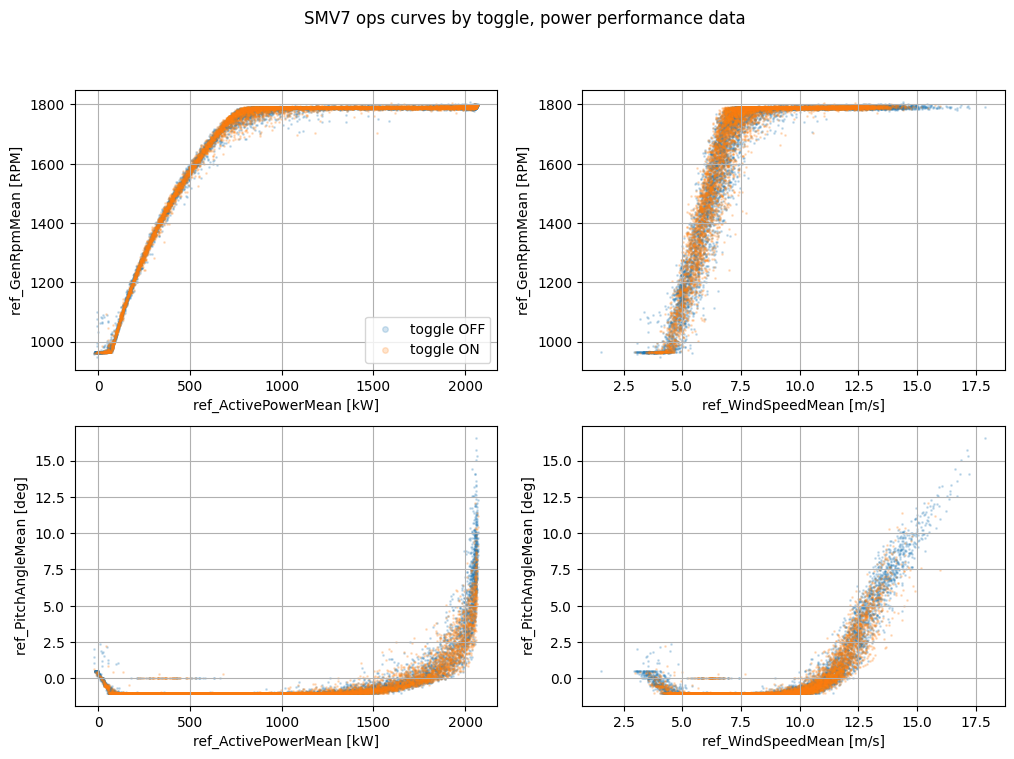

top 2 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
| SMV7 offline |   0.0 |
+--------------+-------+
top 1 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
+--------------+-------+
detrend applied to 38 scenario - directions


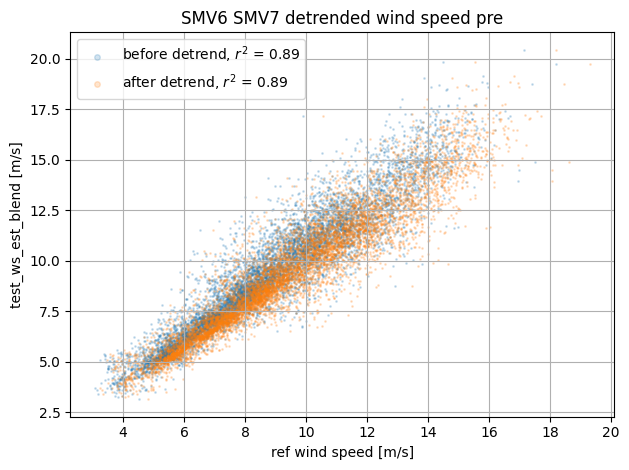

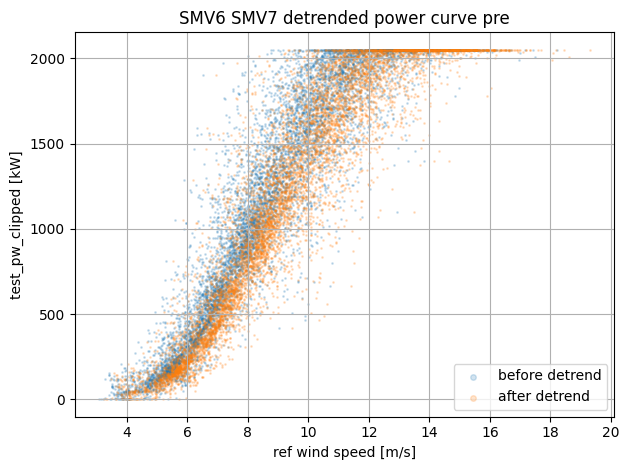

detrend applied to 37 scenario - directions


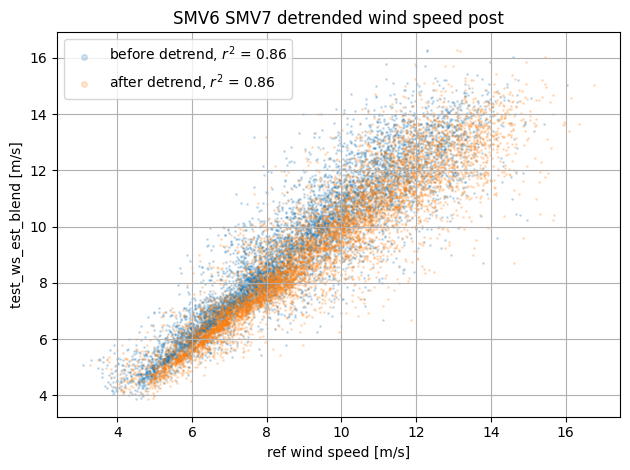

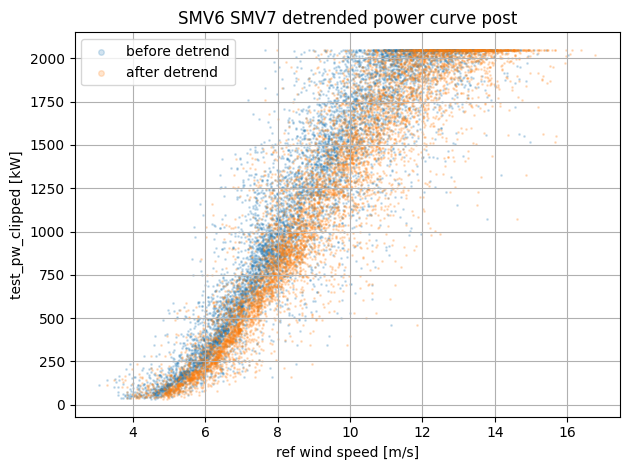

detrend improved pre_df ws r2 by 0.00 (0.89 to 0.89)
detrend improved post_df ws r2 by 0.00 (0.86 to 0.86)
removed 0 bad detrend results
removed 0 bad detrend results


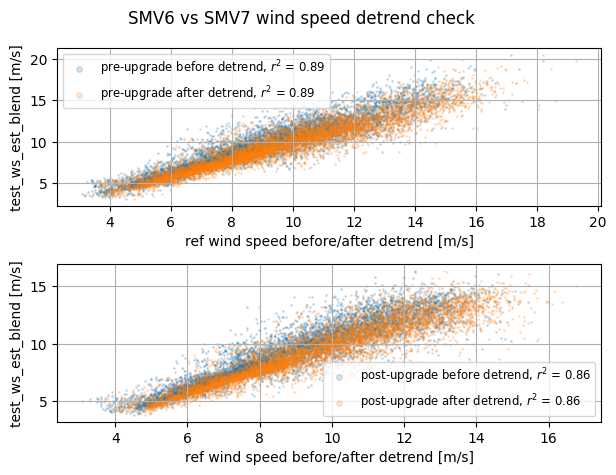

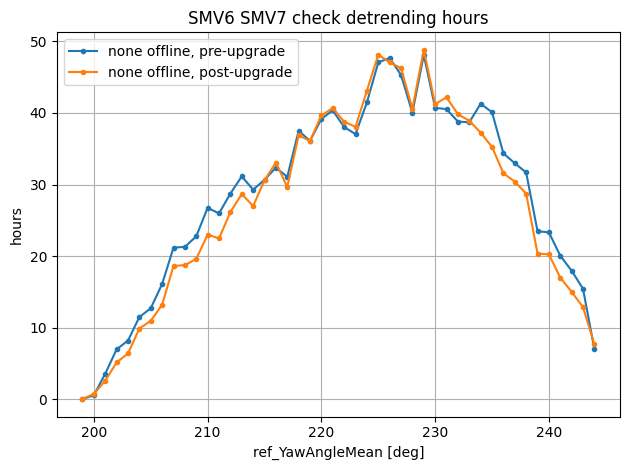

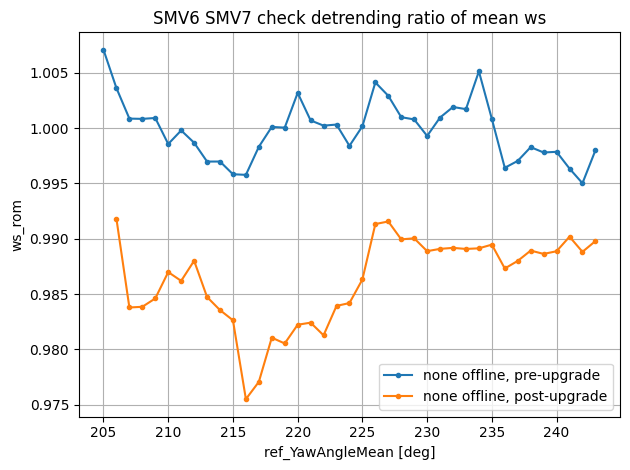

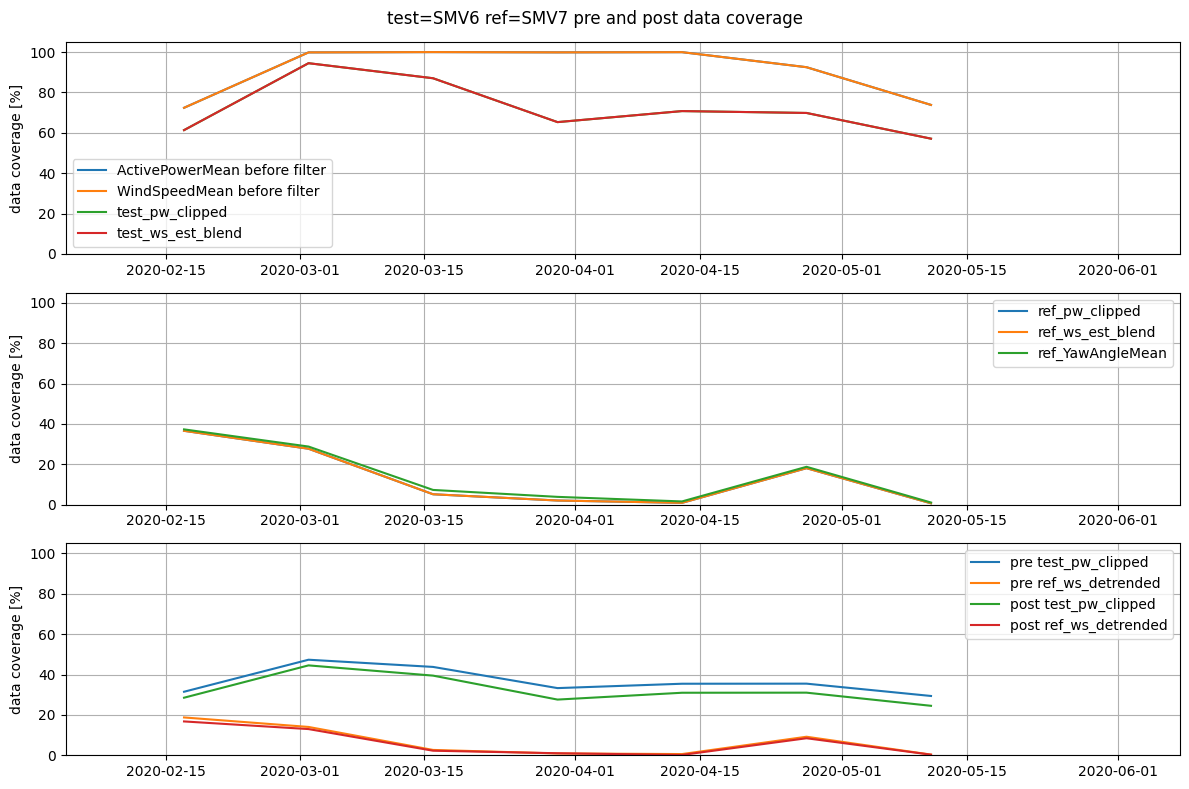

removed 446 [5.5%] rows from pre_df using any_within_timedelta pairing filter
removed 34 [0.5%] rows from post_df using any_within_timedelta pairing filter


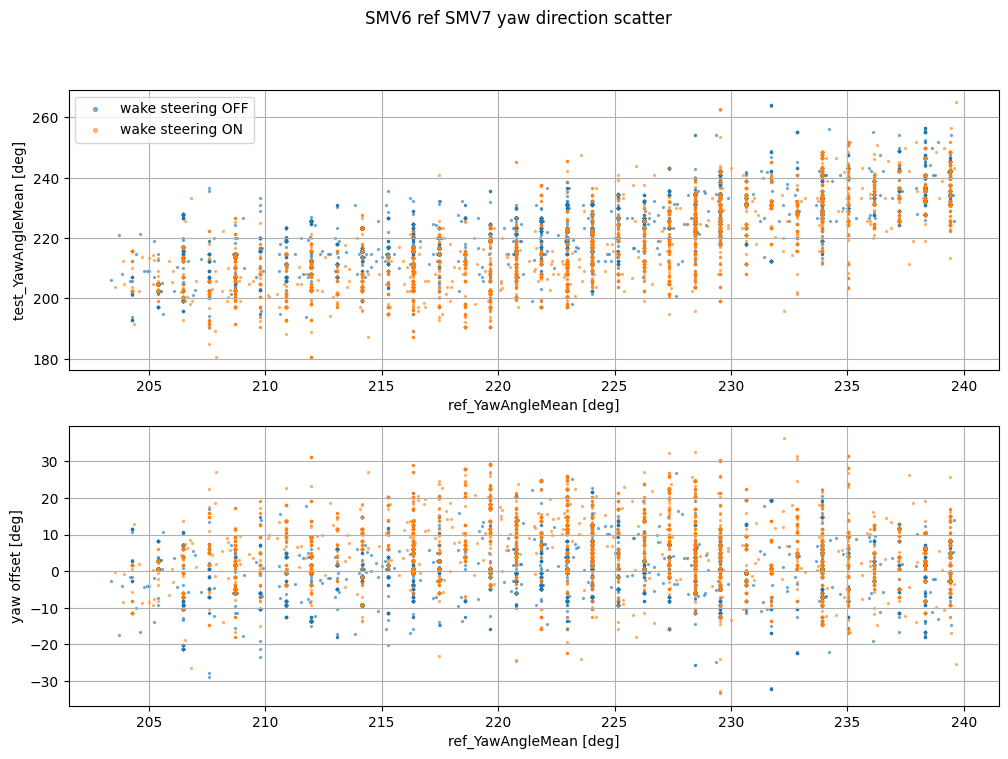

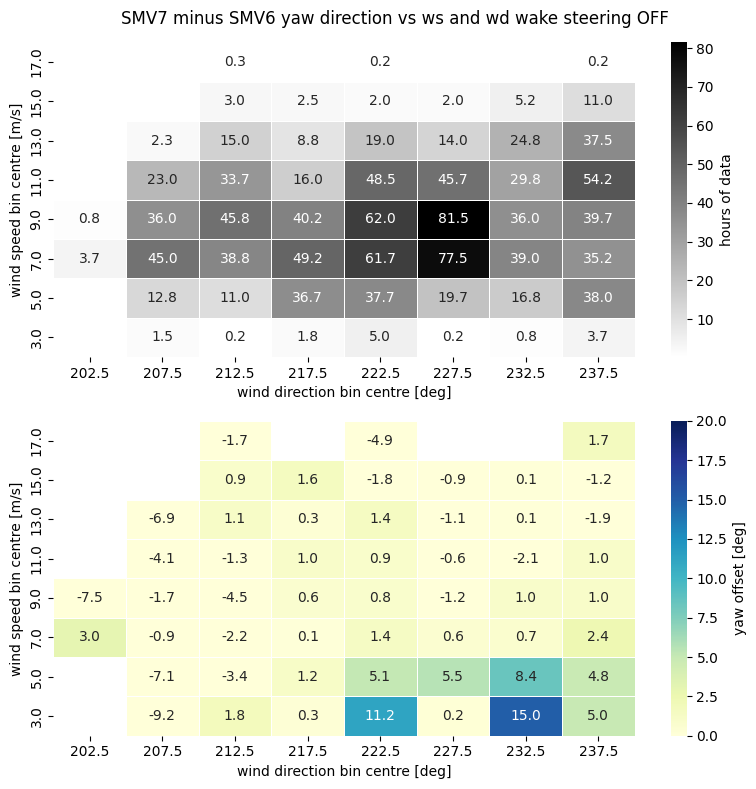

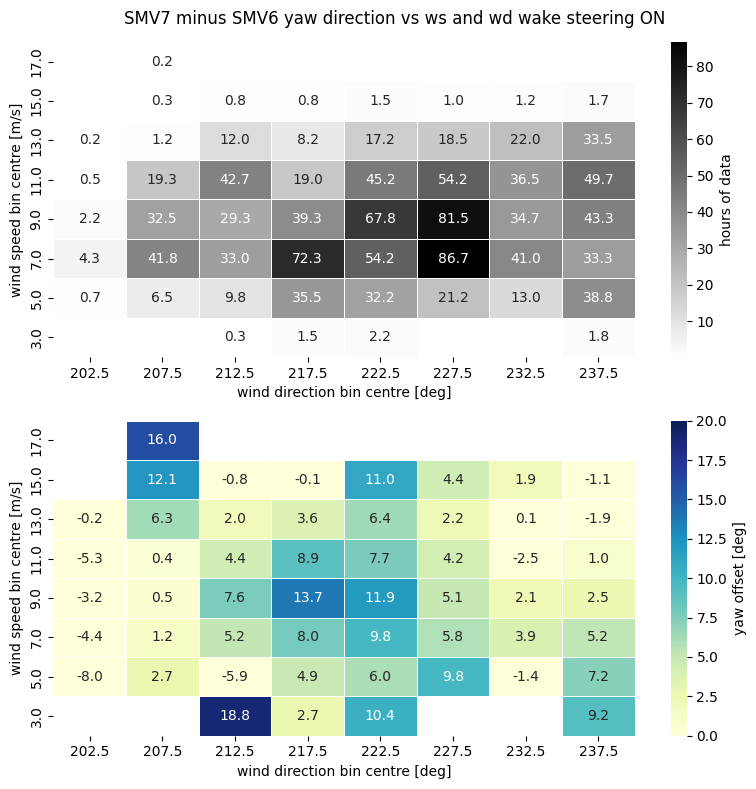

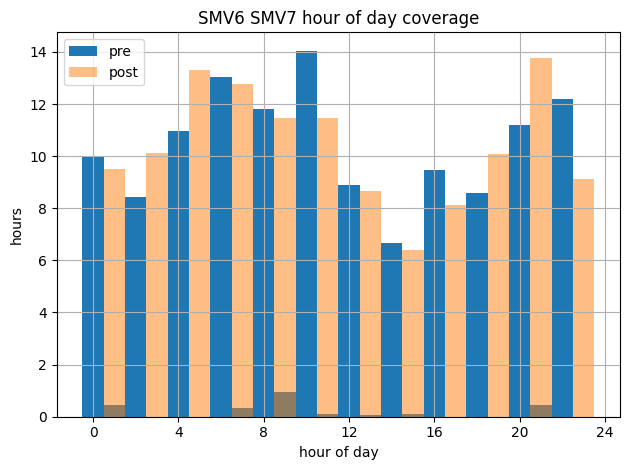

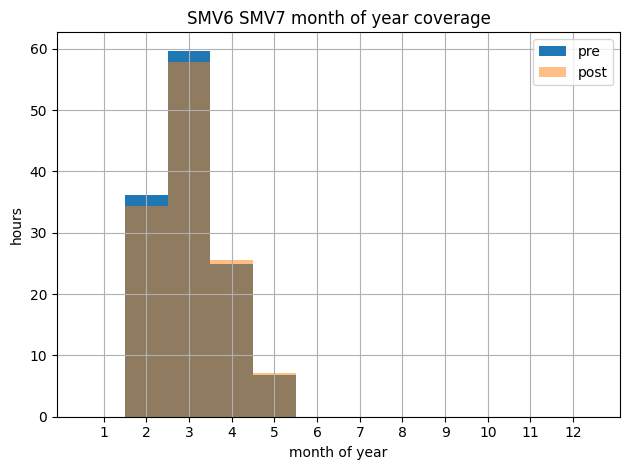

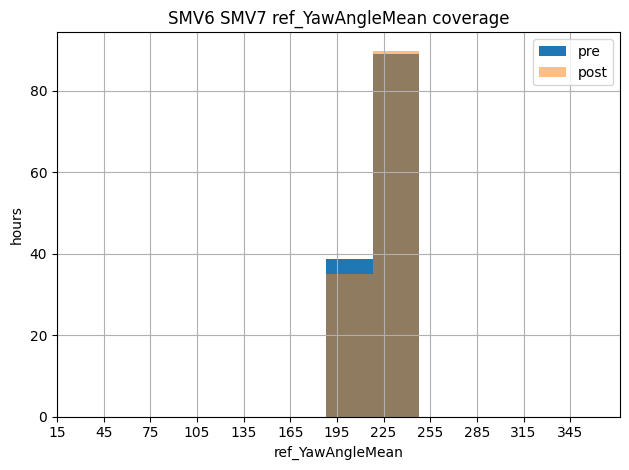

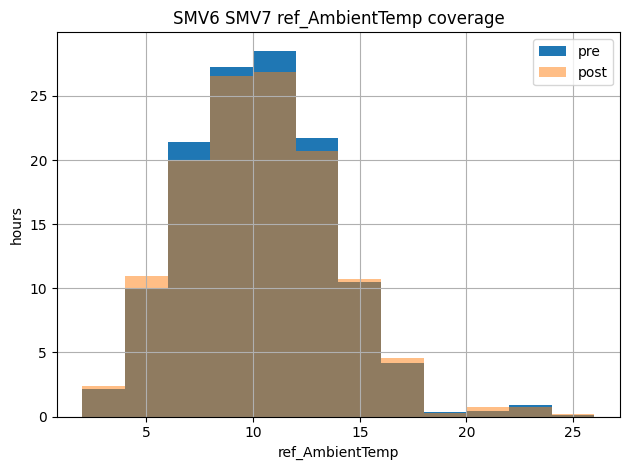

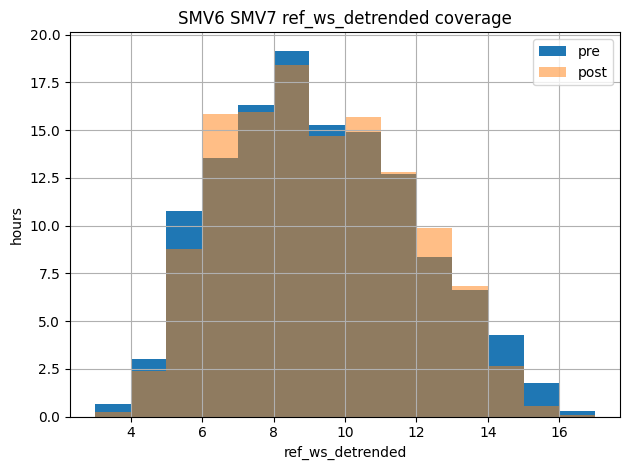

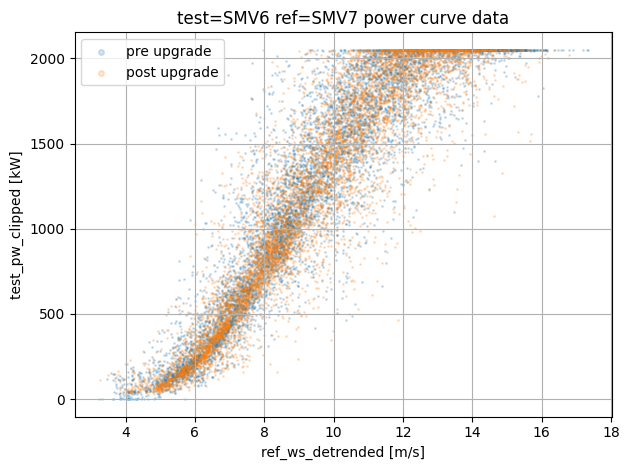

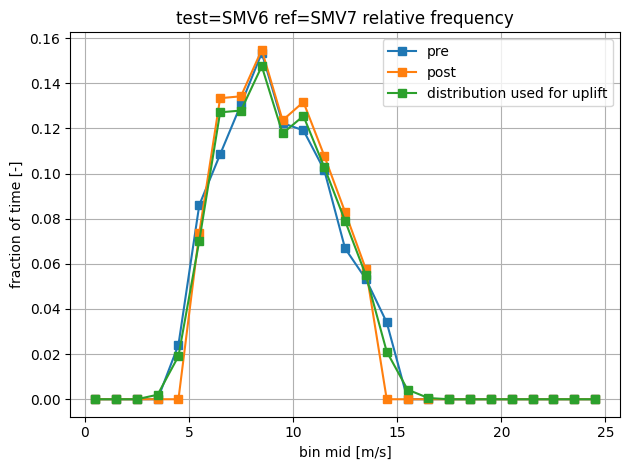

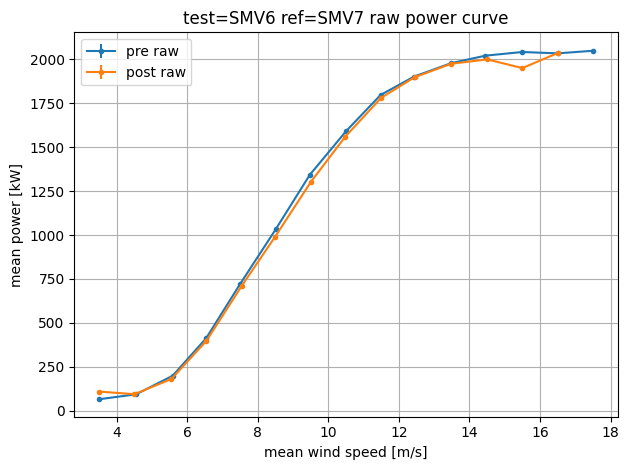

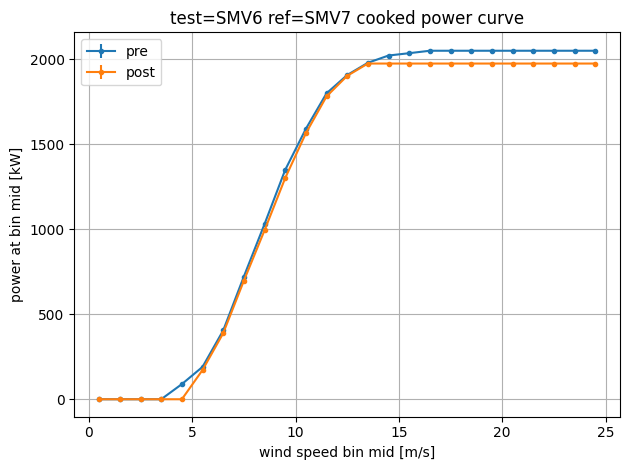

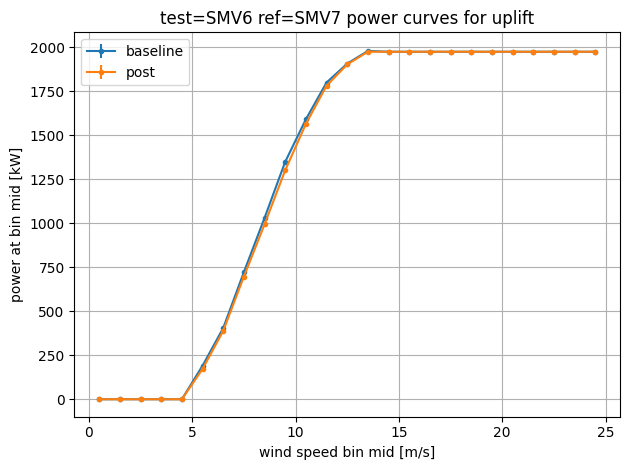

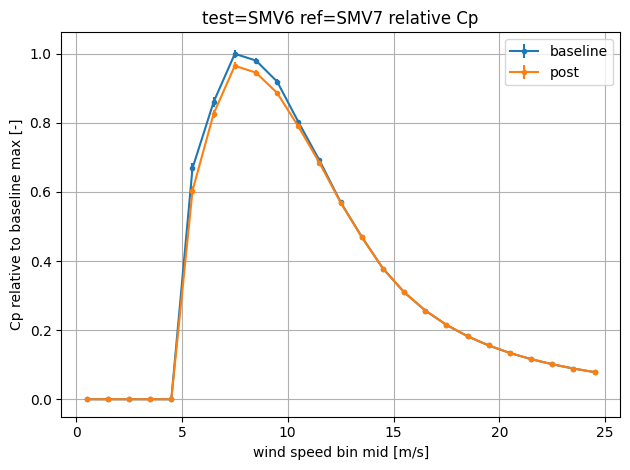

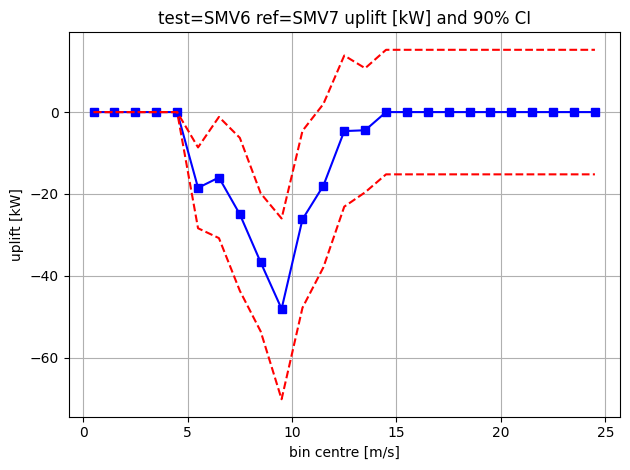

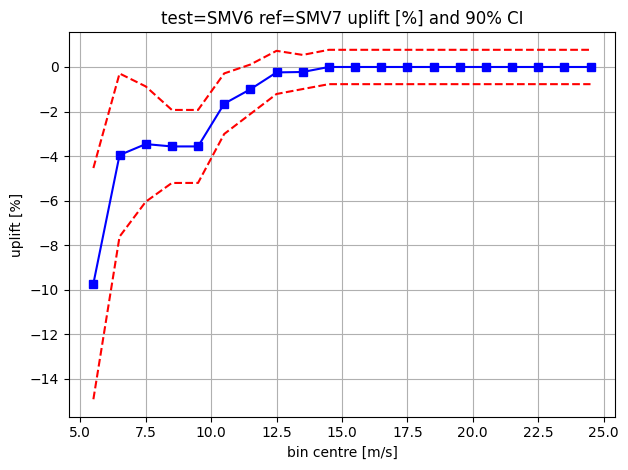

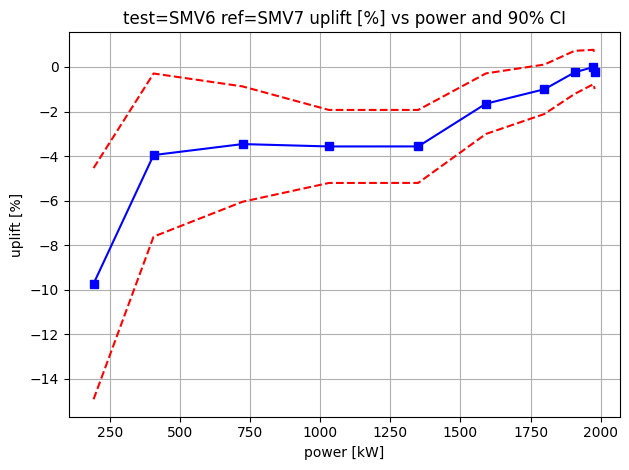

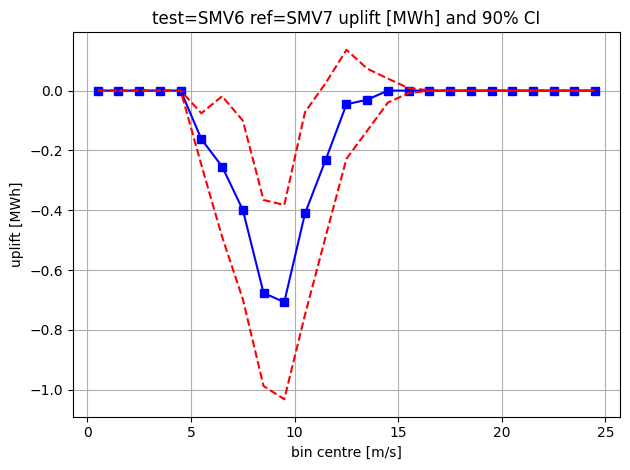

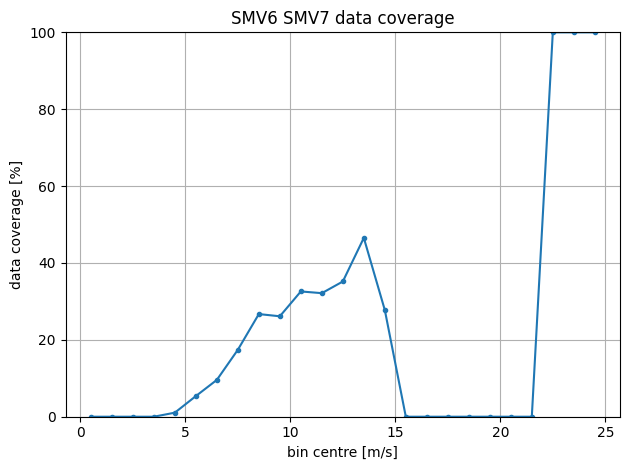


results for test=SMV6 ref=SMV7:

hours pre = 124.9
hours post = 118.9

uplift estimate before adjustments = -2.0 %

power only uplift estimate = -2.0 %
reversed (power only) uplift estimate = -1.9 %

Running block bootstrapping uncertainty analysis n_samples = 400


  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):
  median = -1.9 %
  lower = -3.2 %
  upper = -1.0 %
  unc_one_sigma = 0.7 %

cat A 1 sigma unc = 0.3 %
abs reversal error / 2 = 0.1 %
bootstrap 1 sigma unc = 0.7 %
missing bins scale factor = 1.000
final 1 sigma unc = 0.7 %

final uplift estimate = -1.9 %
final P95 uplift estimate = -3.0 %
final P5 uplift estimate = -0.9 %
{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 314.4465998943834, 'bearing_deg': 173.69483366777283, 'ref_max_northing_error_v_reanalysis': np.float64(2.58400000000006), 'ref_max_northing_error_v_wf': np.float64(2.842170943040401e-14), 'ref_max_ws_drift': np.float64(0.08169535099263392), 'ref_max_ws_drift_pp_period': np.float64(0.08169535099263392), 'ref_powercurve_shift': np.float64(0.0038757067722619), 'ref_rpm_shift': np.float64(0.0012570392311841427), 'ref_pitch_shift': np.float64(-0.07057607084166703), 'detrend_pre_r2_improvement': np.float64(0.0014667284419368487), 'detrend_post_r2_im

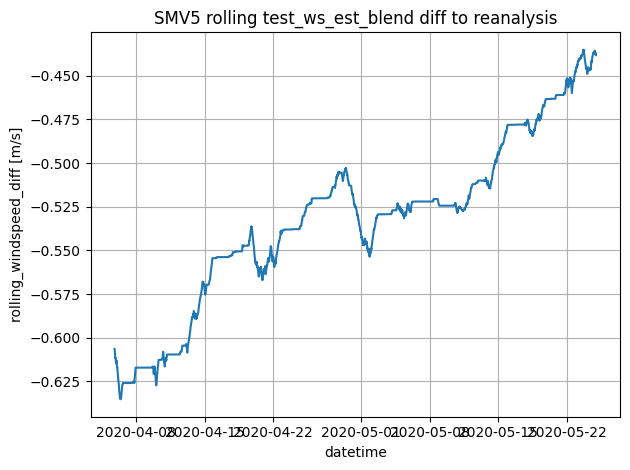

changed 262 [0.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 221 [0.3%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120


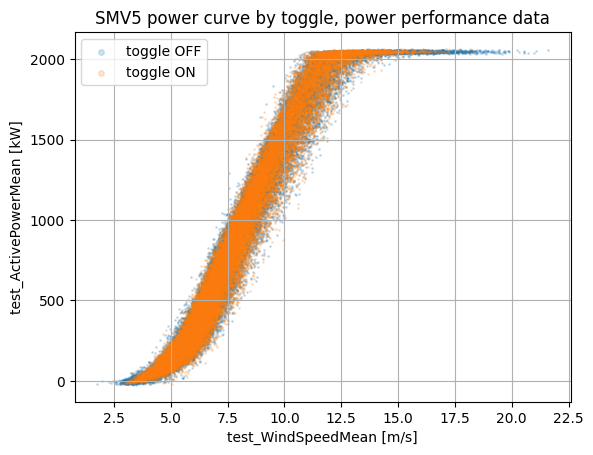

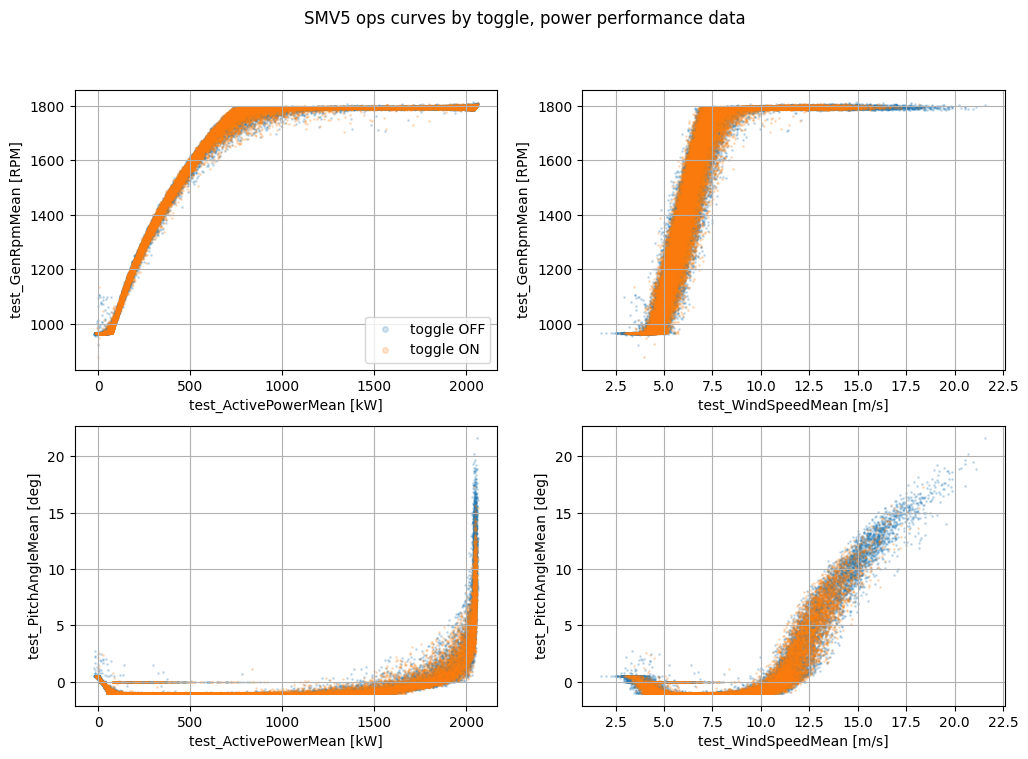

analysing SMV5 SMV7, loop_counter=1
changed 262 [0.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 221 [0.3%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
removed 120279 [85.8%] rows from ref_df using ref_wd_filter
SMV7 wake free directions with data min=203.0 max=240.0
removed 0 [0.0%] rows from ref_df using require_ref_wake_free


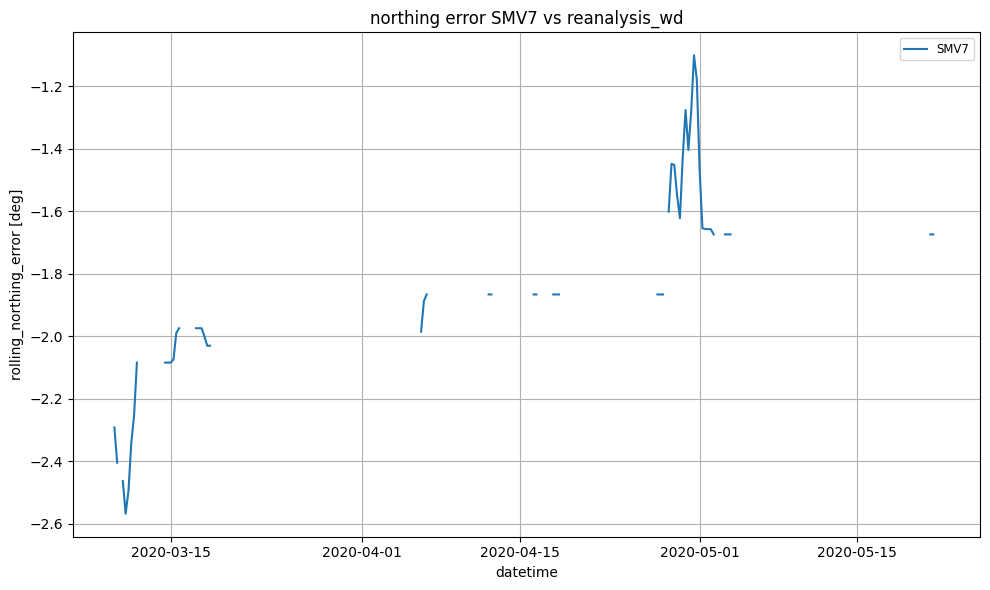

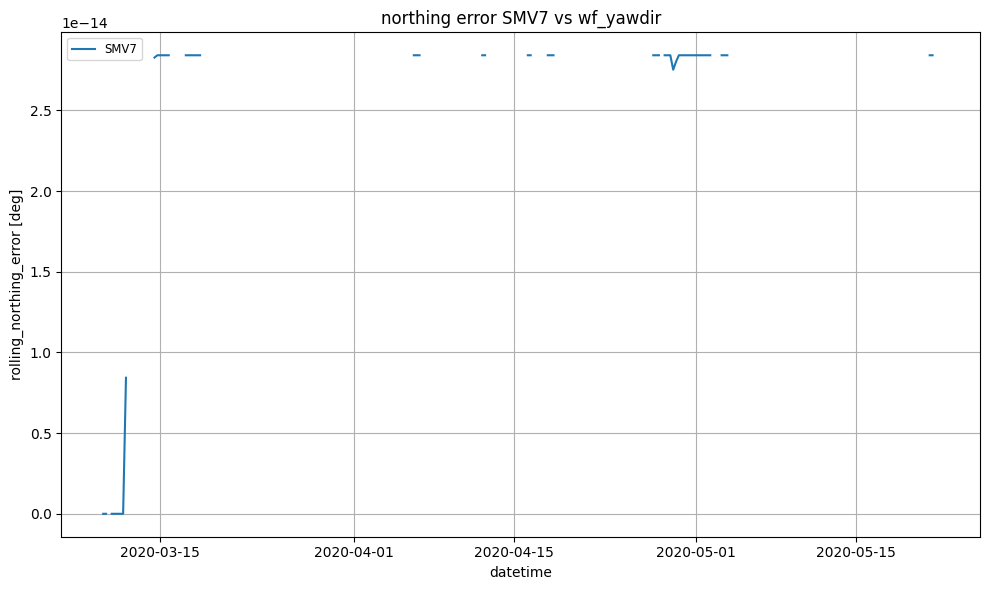

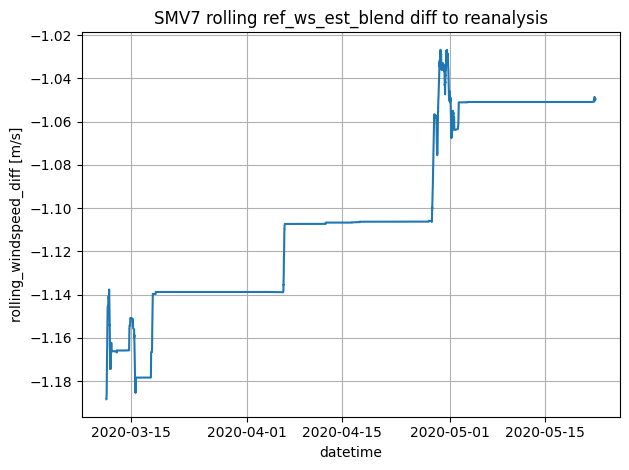

removed 61276 [43.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time
top 5 SMV5 SMV7 waking scenarios [%]:
+-------------------+------+
| none offline      | 86.2 |
| SMV6 offline      |  5.0 |
| SMV6 SMV7 offline |  4.5 |
| unknown           |  4.1 |
| SMV7 offline      |  0.2 |
+-------------------+------+


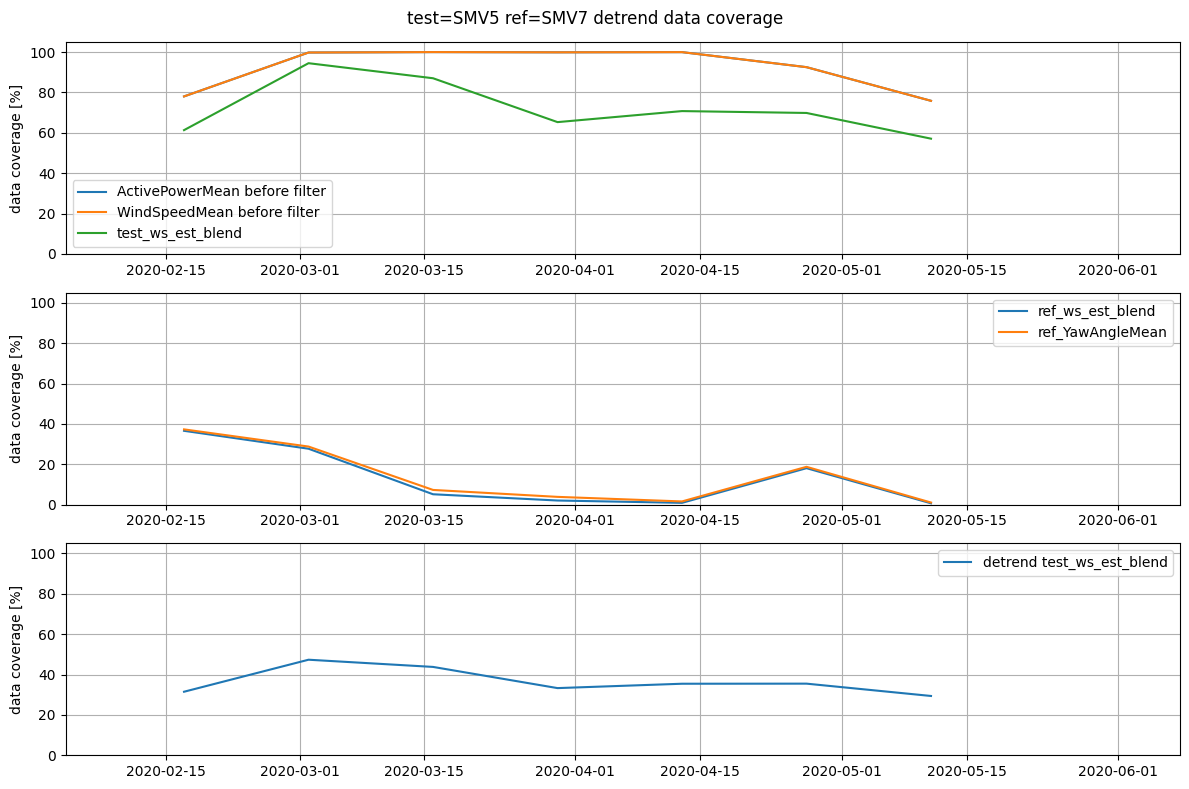

removed 0 bad detrend results


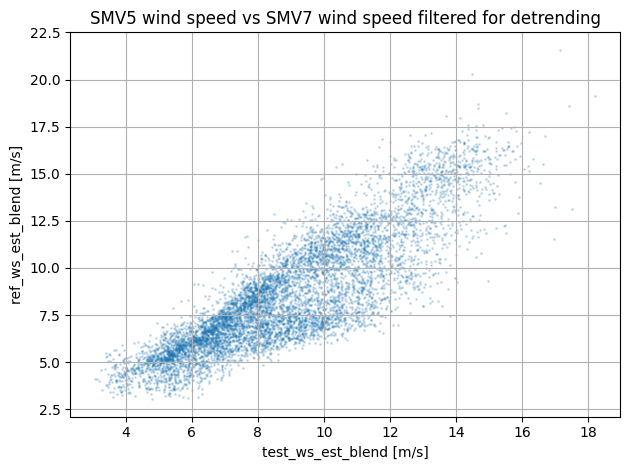

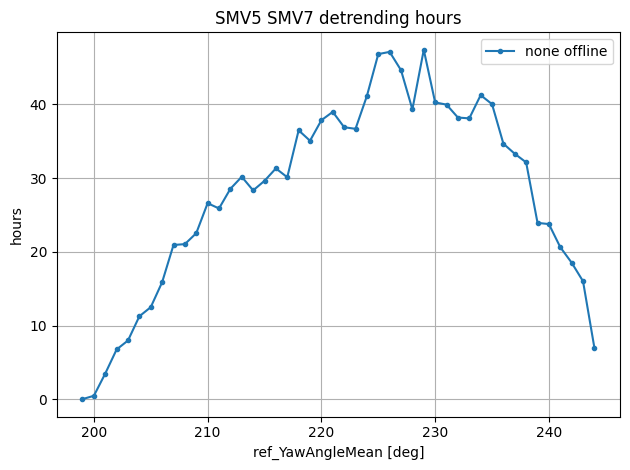

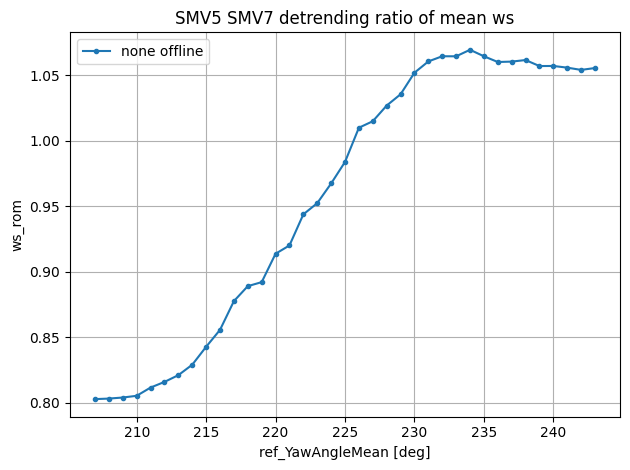

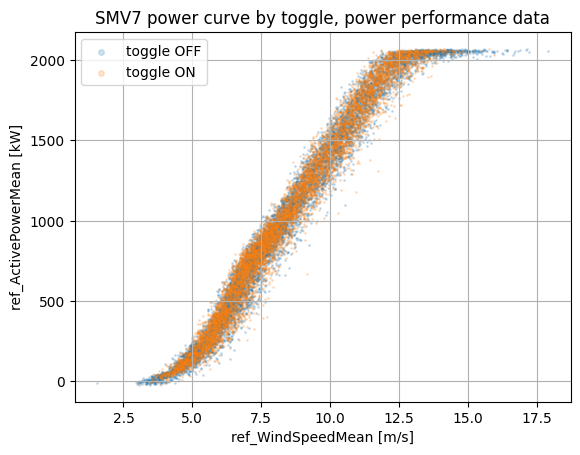

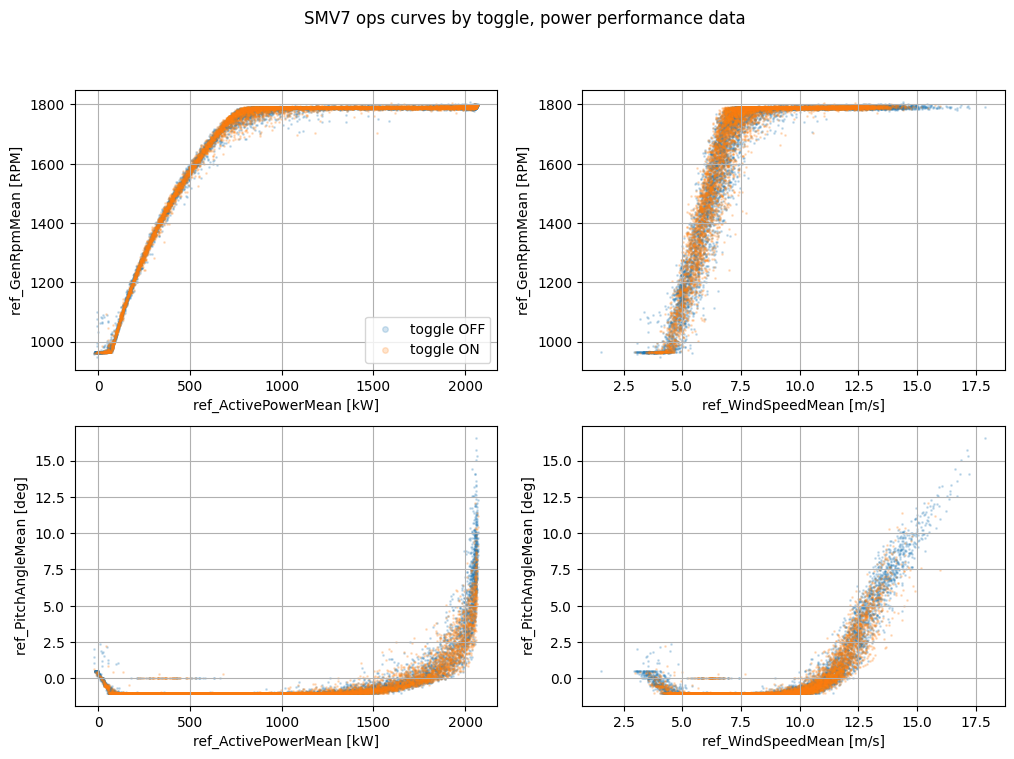

top 5 SMV5 SMV7 waking scenarios [%]:
+-------------------+------+
| none offline      | 86.2 |
| SMV6 offline      |  5.0 |
| SMV6 SMV7 offline |  4.5 |
| unknown           |  4.1 |
| SMV7 offline      |  0.2 |
+-------------------+------+
top 3 SMV5 SMV7 waking scenarios [%]:
+--------------+------+
| none offline | 96.4 |
| unknown      |  3.5 |
| SMV7 offline |  0.1 |
+--------------+------+
detrend applied to 77 scenario - directions


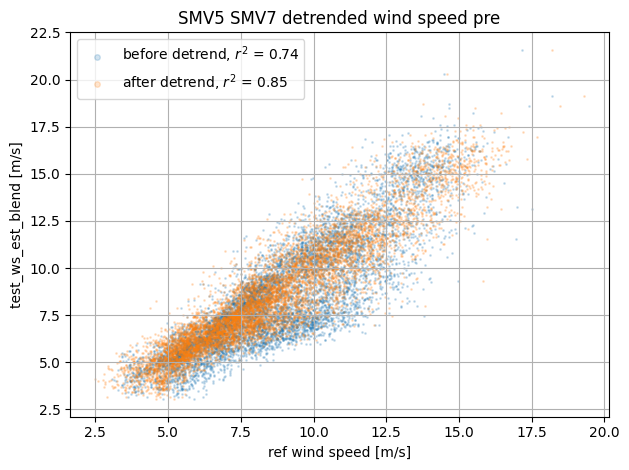

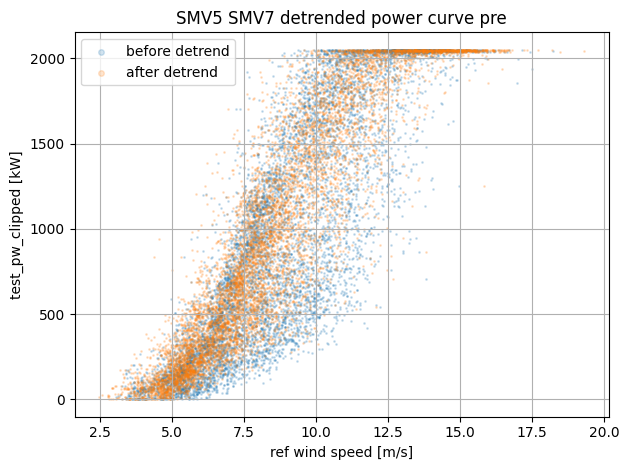

detrend applied to 48 scenario - directions


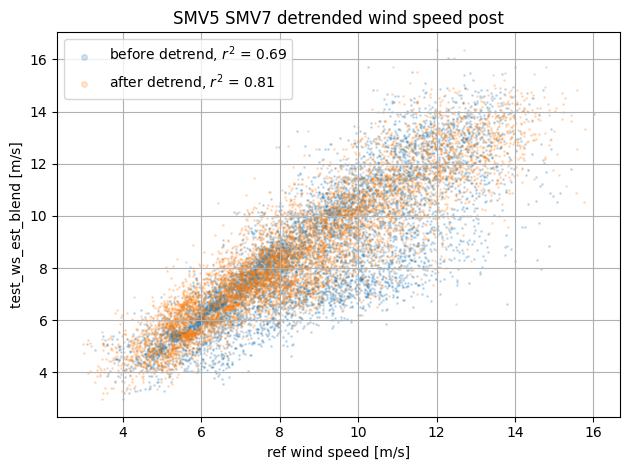

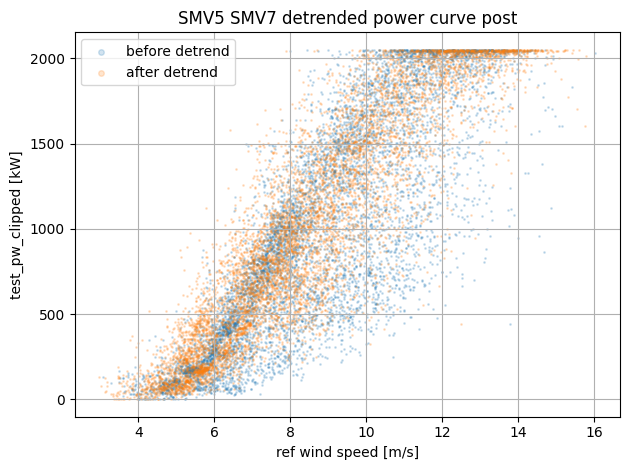

detrend improved pre_df ws r2 by 0.11 (0.74 to 0.85)
detrend improved post_df ws r2 by 0.12 (0.69 to 0.81)
removed 0 bad detrend results
removed 0 bad detrend results


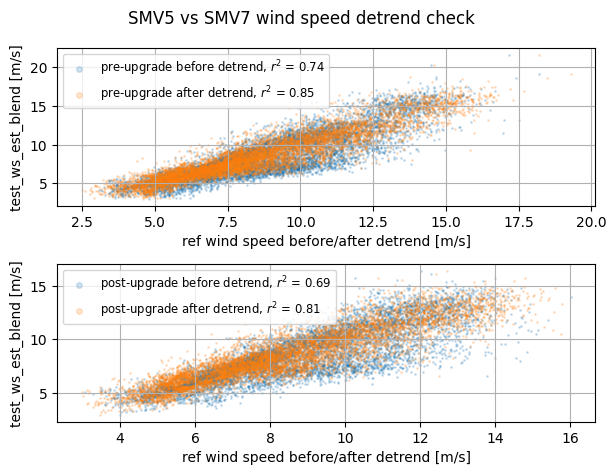

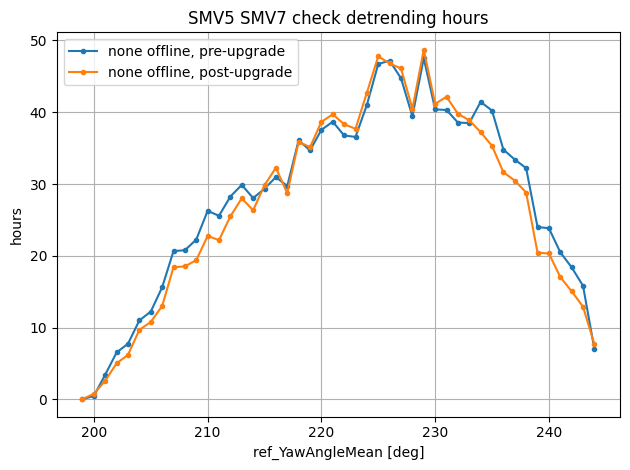

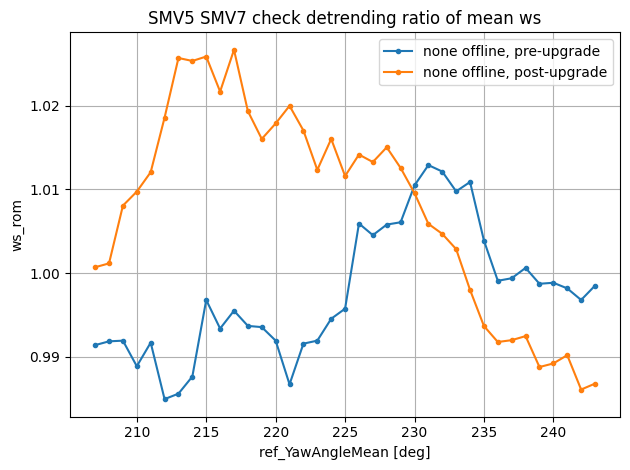

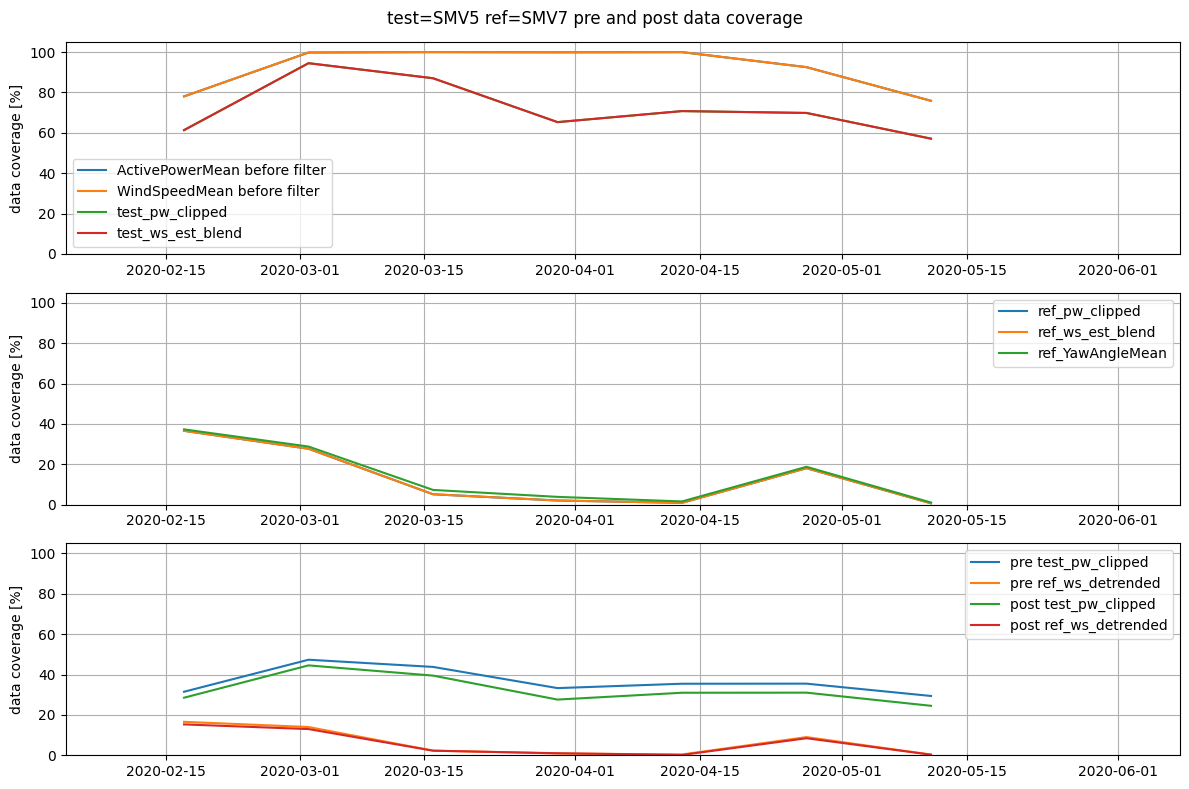

removed 446 [5.5%] rows from pre_df using any_within_timedelta pairing filter
removed 34 [0.5%] rows from post_df using any_within_timedelta pairing filter


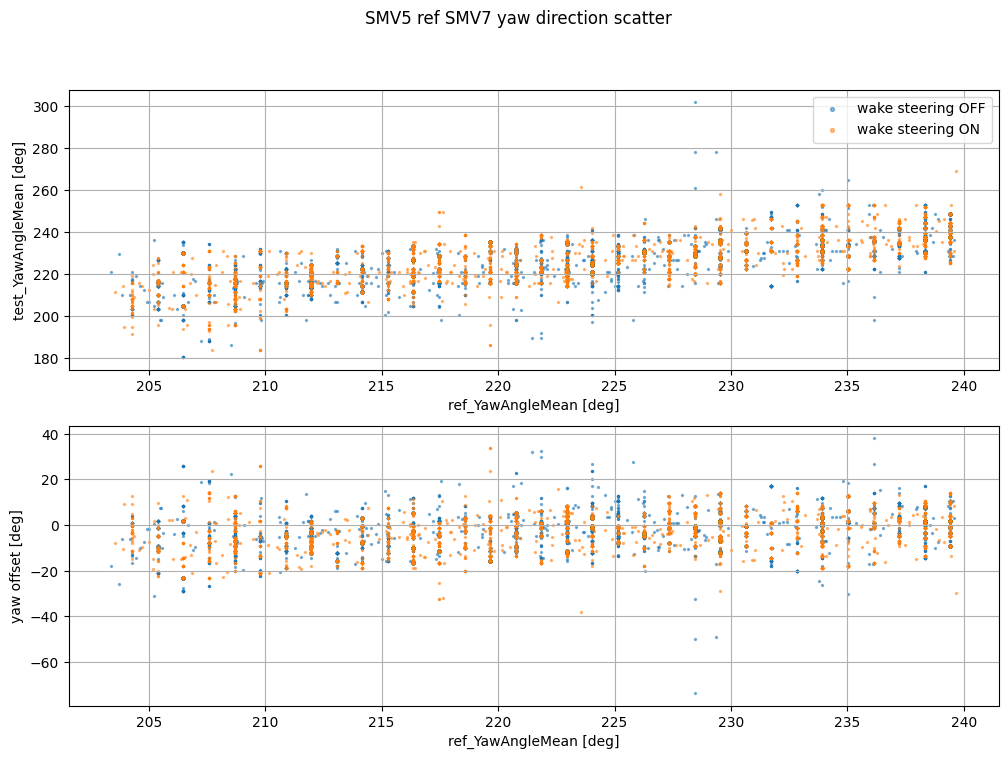

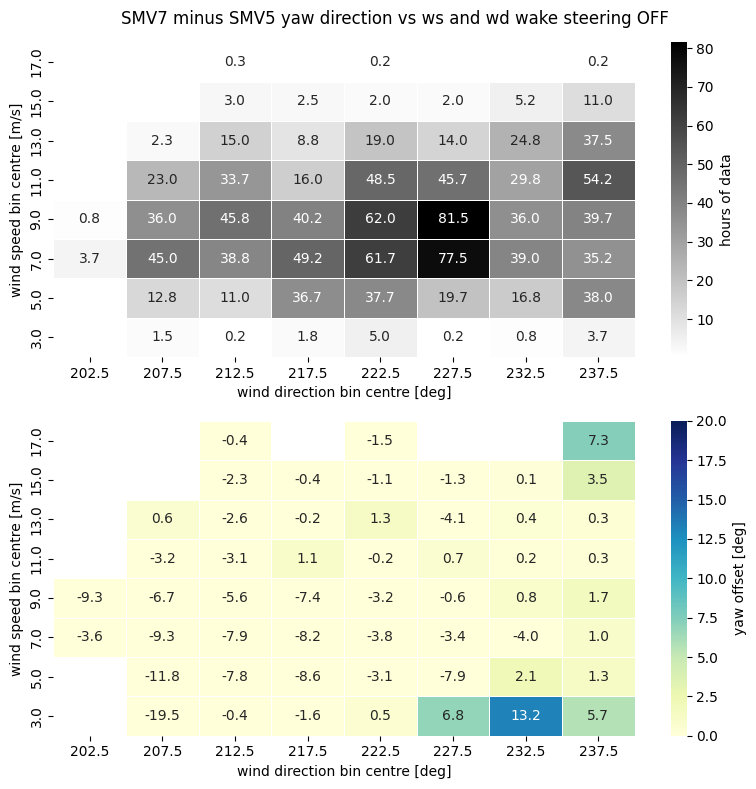

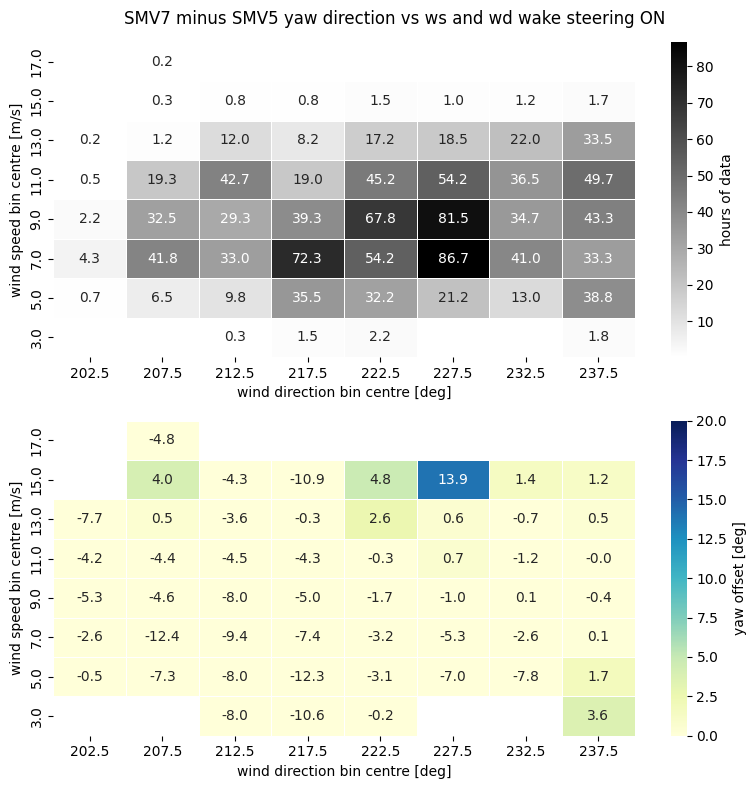

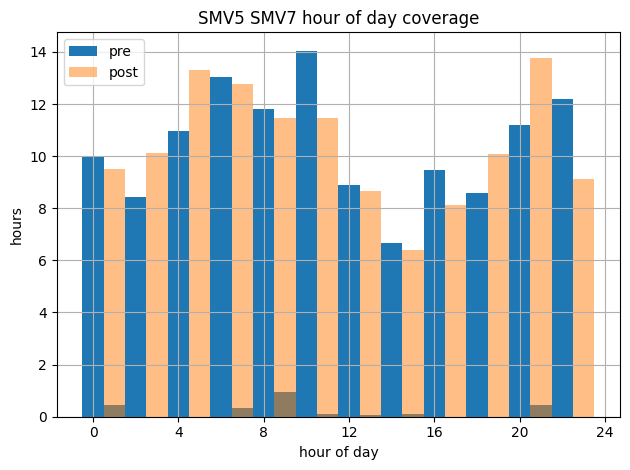

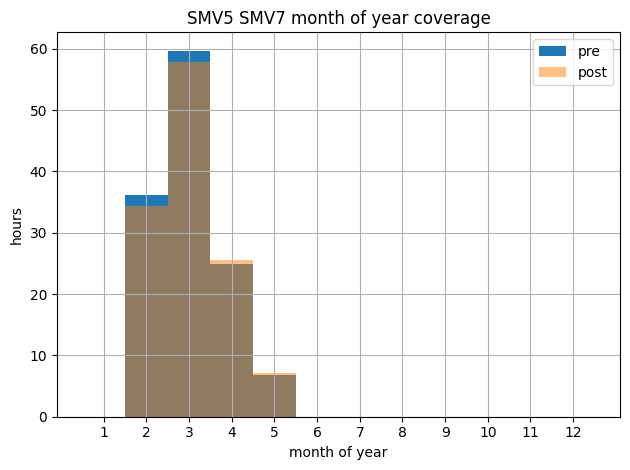

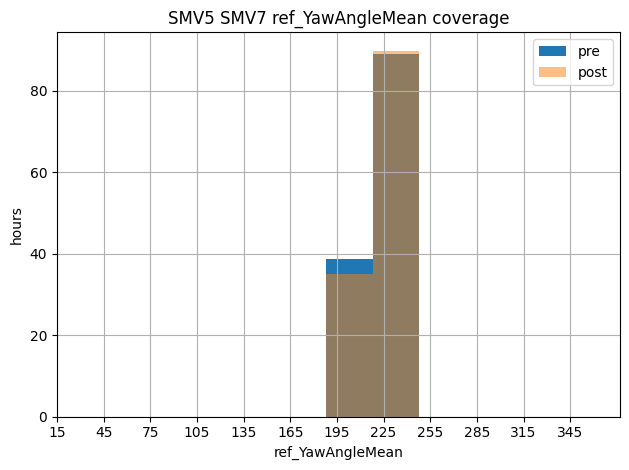

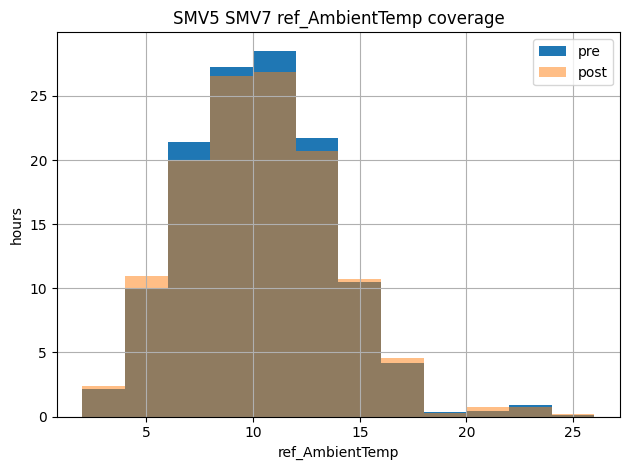

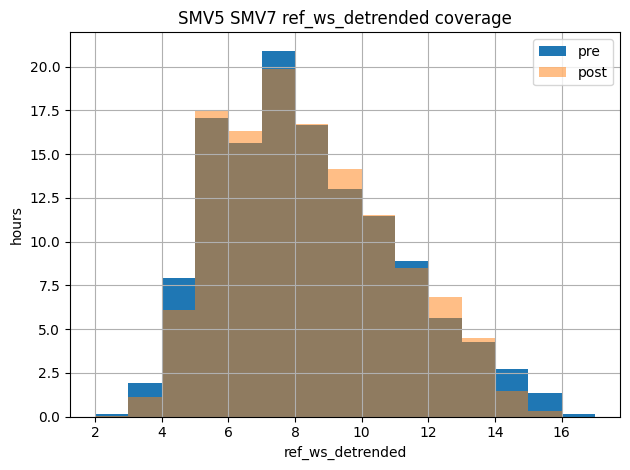

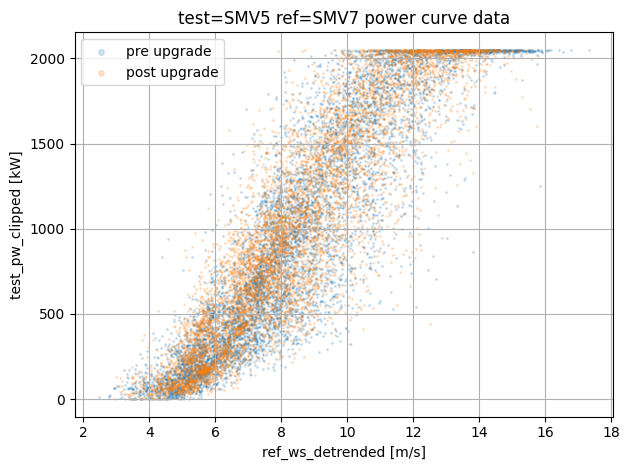

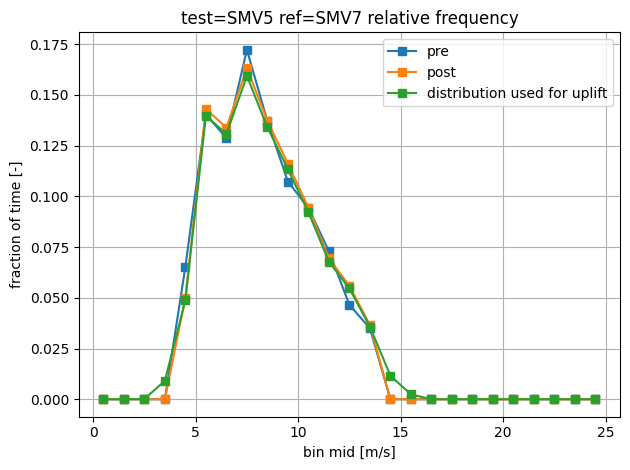

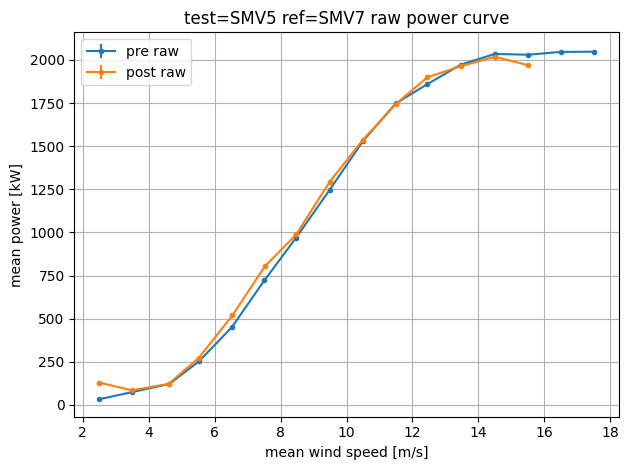

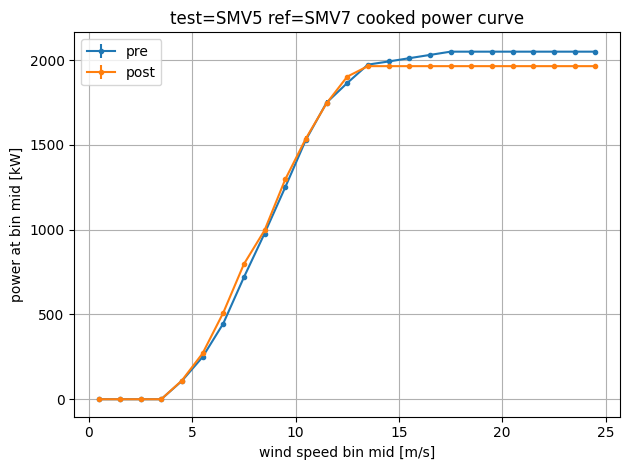

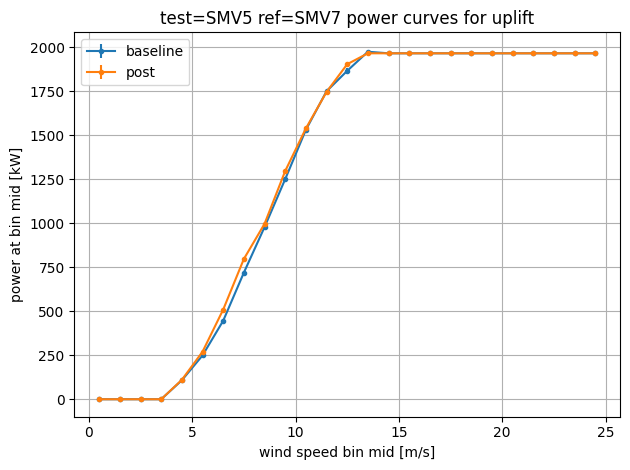

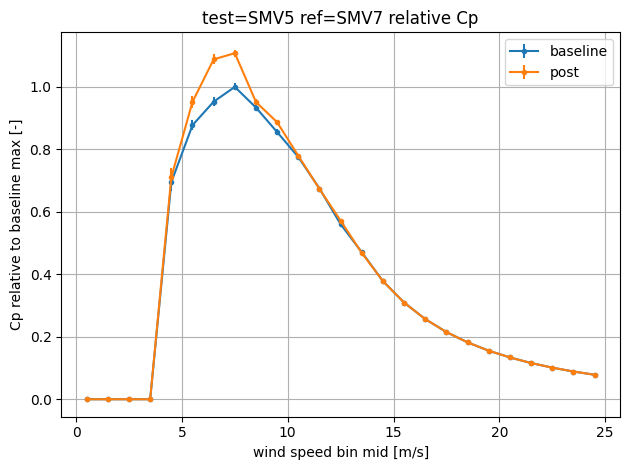

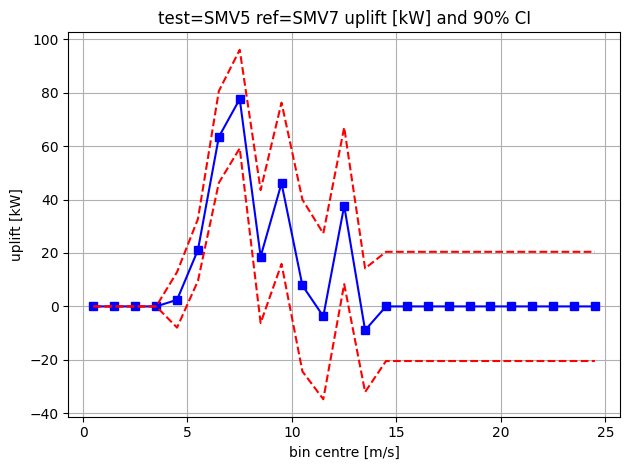

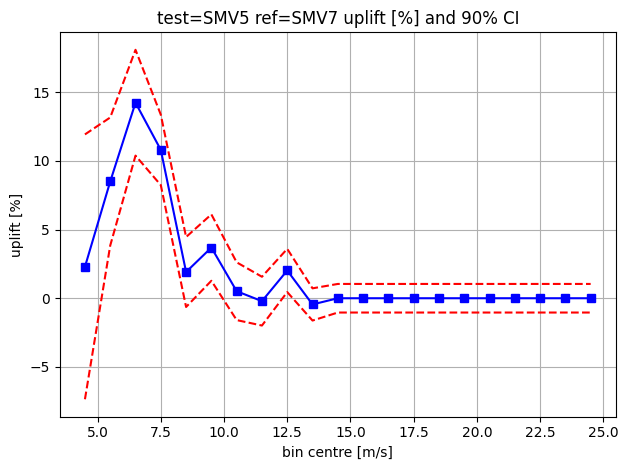

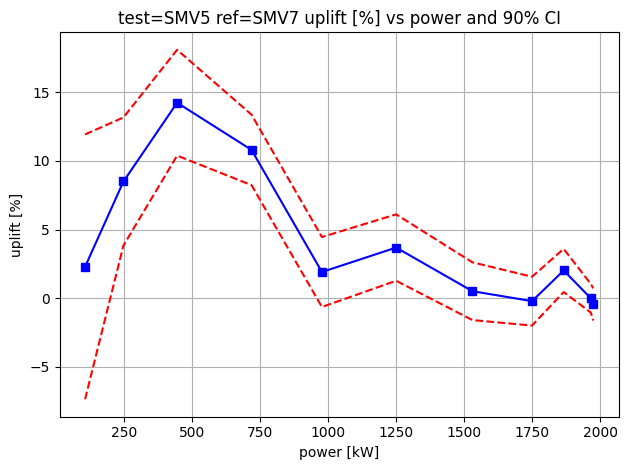

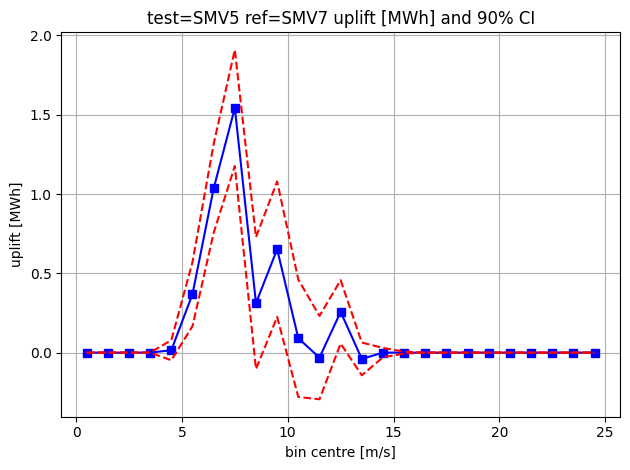

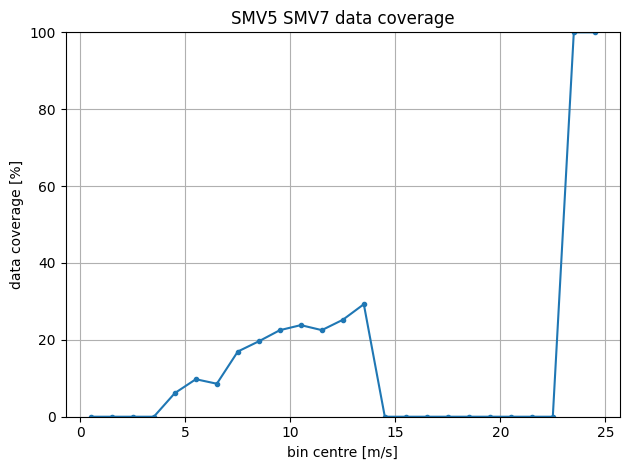


results for test=SMV5 ref=SMV7:

hours pre = 121.4
hours post = 121.9

uplift estimate before adjustments = 3.6 %

power only uplift estimate = 3.6 %
reversed (power only) uplift estimate = 3.2 %

Running block bootstrapping uncertainty analysis n_samples = 400


  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):
  median = 3.3 %
  lower = 1.3 %
  upper = 5.6 %
  unc_one_sigma = 1.3 %

cat A 1 sigma unc = 0.5 %
abs reversal error / 2 = 0.2 %
bootstrap 1 sigma unc = 1.3 %
missing bins scale factor = 1.000
final 1 sigma unc = 1.3 %

final uplift estimate = 3.4 %
final P95 uplift estimate = 1.2 %
final P5 uplift estimate = 5.5 %
{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 591.1178519927024, 'bearing_deg': 190.23567745705736, 'ref_max_northing_error_v_reanalysis': np.float64(2.58400000000006), 'ref_max_northing_error_v_wf': np.float64(2.842170943040401e-14), 'ref_max_ws_drift': np.float64(0.08169535099263392), 'ref_max_ws_drift_pp_period': np.float64(0.08169535099263392), 'ref_powercurve_shift': np.float64(0.0038757067722619), 'ref_rpm_shift': np.float64(0.0012570392311841427), 'ref_pitch_shift': np.float64(-0.07057607084166703), 'detrend_pre_r2_improvement': np.float64(0.11074453455909039), 'detrend_post_r2_improvemen

CPU times: total: 1min 36s
Wall time: 4min 31s


In [14]:
%%time
from wind_up.main_analysis import run_wind_up_analysis

results_per_test_ref_df = run_wind_up_analysis(assessment_inputs)

In [15]:
from helpers import format_and_print_results_table

format_and_print_results_table(results_per_test_ref_df)

+-----------+-------------+-----------------+----------------------+--------------+-------------+--------------------------+-------------------------+------------------------+
|  turbine  |  reference  |  energy uplift  |  uplift uncertainty  |  uplift P95  |  uplift P5  |  valid hours toggle off  |  valid hours toggle on  |  mean power toggle on  |
+===========+=============+=================+======================+==============+=============+==========================+=========================+========================+
|   SMV6    |    SMV7     |      -1.9%      |         0.7%         |    -3.0%     |    -0.9%    |          124.9           |          118.9          |          1145          |
|   SMV5    |    SMV7     |      3.4%       |         1.3%         |     1.2%     |    5.5%     |          121.4           |          121.9          |          982           |
+-----------+-------------+-----------------+----------------------+--------------+-------------+-----------------------

turbine reference energy uplift uplift uncertainty uplift P95 uplift P5  \
0    SMV6      SMV7         -1.9%               0.7%      -3.0%     -0.9%   
1    SMV5      SMV7          3.4%               1.3%       1.2%      5.5%   

   valid hours toggle off  valid hours toggle on  mean power toggle on  
0              124.900000             118.933333                  1145  
1              121.433333             121.900000                   982

## calculate the net uplift of this wake steering test

For wake steering we expect the steering turbine uplift to be negative and the benefitting turbine uplift to be positive (which are both true in this example). The steering turbine will almost always be more productive than the benefitting turbine since it is usually in a windier (un-waked) location, therefore the % uplift of the benefitting turbine needs to be much higher than the % loss of the steering turbine for the net uplift to be positive. The function below properly calculates the net uplift and combined uncertainty.

In [17]:
from wind_up.combine_results import calc_net_uplift

net_p50, net_p95, net_p5 = calc_net_uplift(results_per_test_ref_df, confidence=0.9)
f"net P50: {net_p50:.3%}, net P95: {net_p95:.3%}, net P5: {net_p5:.3%}"

'net P50: 0.435%, net P95: -0.691%, net P5: 1.561%'